<a href="https://colab.research.google.com/github/Shegy12/GAN-for-generating-artificial-ECG-data/blob/master/EKG_GAN_SGD3_latent100_01norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project description**

Generative Adversial Network for Artificial ECG Generation


# **Install python packages**

In [2]:
!python --version
import keras
!pip3 install scipy keras
print(keras.__version__)


Python 3.6.9


Using TensorFlow backend.


2.3.1


# **Imports**

In [0]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import sys
import os
import datetime
from enum import Enum
from pathlib import Path
from timeit import default_timer as timer

# numpy
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn

# Basics of Python data handling and visualization

import matplotlib.pyplot as plt
from matplotlib import pyplot
import scipy.io as sio
from timeit import default_timer as timer
import matplotlib as mpl

#keras
from keras.models import Sequential
from keras.layers import Conv1D, TimeDistributed, MaxPooling1D, Dense, Softmax, Flatten, LeakyReLU, Activation, BatchNormalization, Dropout, LSTM, Bidirectional, Reshape
from keras.activations import relu
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.initializers import RandomNormal

#preprocessing
import random
from sklearn import preprocessing
import scipy.stats
from scipy.signal import resample

# **Google drive**

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

GOOGLE_DRIVE_PATH = Path('/content/gdrive/My Drive')
WORKDIR = 'ECG_DATA' # nazov pracovneho priecinku
WORKDIR_PATH = GOOGLE_DRIVE_PATH / WORKDIR

if not os.path.exists(WORKDIR_PATH):
          os.mkdir(WORKDIR_PATH)

          

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Paths**

In [0]:
#ANNOTATION - nazvy a anotacie/labely
ANNOTATION_PATH = WORKDIR_PATH / "annotFull.mat"
#MATDATA - signal database (.mat)
SINUS_PATH = WORKDIR_PATH / "SINUS"
AF_SV_VR_PATH = WORKDIR_PATH / "AF_SV_VR"
AB_AV_BB_PV_PATH = WORKDIR_PATH / "AB_AV_BB_PV"
OTHER_NOISY_PATH = WORKDIR_PATH / "OTHER_NOISY"

#**Data manipulation** (signals and labels)

In [0]:
matlab_data = sio.loadmat(file_name=ANNOTATION_PATH)
Ydata = matlab_data['YData']
print('Shape of Ydata ->' + str(Ydata.shape)+', 6884 = number of signals, 2 = signal_names,signal_labels')

signal_names = Ydata[:,0] 
signal_names = [str(signal_names).replace('[', '').replace("'", '').replace(']', '') for signal_names in signal_names.tolist()[:]]
#print('Number of signals ->' + str(len(signal_names)))
print('Names of signals ->' + str(signal_names))

signal_labels = Ydata[:,1]
#signal_labels = [str(signal_labels).replace('[', '').replace(']', '').replace(' ','') for signal_labels in signal_labels.tolist()[:]]
#print('Number of labels ->' + str(len(signal_labels)))
print('Signal labels ->' + str(signal_labels))

labels_names = matlab_data['annotLabel']
labels_names = [str(labels_names).replace('[', '').replace("'", '').replace(']', '').replace('', '') for labels_names in labels_names.tolist()[0]]
print('Names of labels ->' + str(labels_names))

# replace("'",'')


Shape of Ydata ->(6884, 2), 6884 = number of signals, 2 = signal_names,signal_labels
Names of signals ->['EB0000018570.mat', 'EB0000018571.mat', 'EB0000018572.mat', 'EB0000018573.mat', 'EB0000018574.mat', 'EB0000018575.mat', 'EB0000018576.mat', 'EB0000018577.mat', 'EB0000018578.mat', 'EB0000018579.mat', 'EB0000018580.mat', 'EB0000018581.mat', 'EB0000018582.mat', 'EB0000018583.mat', 'EB0000018584.mat', 'EB0000018585.mat', 'EB0000018586.mat', 'EB0000018587.mat', 'EB0000018588.mat', 'EB0000018589.mat', 'EB0000018590.mat', 'EB0000018591.mat', 'EB0000018592.mat', 'EB0000018593.mat', 'EB0000018594.mat', 'EB0000018595.mat', 'EB0000018596.mat', 'EB0000018597.mat', 'EB0000018598.mat', 'EB0000018599.mat', 'EB0000018600.mat', 'EB0000018601.mat', 'EB0000018602.mat', 'EB0000018603.mat', 'EB0000018604.mat', 'EB0000018605.mat', 'EB0000018606.mat', 'EB0000018607.mat', 'EB0000018608.mat', 'EB0000018609.mat', 'EB0000018610.mat', 'EB0000018611.mat', 'EB0000018612.mat', 'EB0000018613.mat', 'EB0000018614.m

# **Creating the database**

**Signaly1** = Signals with MULTIPLE labels (including specific type of label)

**Signaly2** = Signals with ONLY one type of label

In [0]:
AF1=[]; SI1=[];SV1=[];VR1=[];OT1=[];AV1=[];BB1=[];AB1=[];PV1=[];NO1=[]
AF2=[]; SI2=[];SV2=[];VR2=[];OT2=[];AV2=[];BB2=[];AB2=[];PV2=[];NO2=[]

def signal_type(i):
  switcher={
      0:AF2,1:SI2,2:SV2,3:VR2,4:OT2,5:AV2,6:BB2,7:AB2,8:PV2,9:NO2,
      10:AF1,11:SI1,12:SV1,13:VR1,14:OT1,15:AV1,16:BB1,17:AB1,18:PV1,19:NO1
    }
  return switcher.get(i,"Invalid number of label")


prefix=['AF2','SI2','SV2','VR2','OT2','AV2','BB2','AB2','PV2','NO1','AF1','SI1','SV1','VR1','OT1','AV1','BB1','AB1','PV1','NO1']

for counter in range(10,20):
  for item in Ydata.tolist():
    if list(item[1][0])[counter-10] == 1:
      signal_type(counter).append(str(prefix[counter])+str(item[0]).replace('[', '').replace("'", '').replace(']', ''))


print('Signals with MANY types of labels including specific type of label:')
print('')
print('Number of AF1 signals ->' + str(len(signal_type(10))))
print('Number of SI1 signals ->' + str(len(signal_type(11))))
print('Number of SV1 signals ->' + str(len(signal_type(12))))
print('Number of VR1 signals ->' + str(len(signal_type(13))))
print('Number of OT1 signals ->' + str(len(signal_type(14))))
print('Number of AV1 signals ->' + str(len(signal_type(15))))
print('Number of BB1 signals ->' + str(len(signal_type(16))))
print('Number of AB1 signals ->' + str(len(signal_type(17))))
print('Number of PV1 signals ->' + str(len(signal_type(18))))
print('Number of NO1 signals ->' + str(len(signal_type(19))))
print('')

counter=0
for counter in range(10):
  for item in Ydata.tolist():
    if list(item[1][0])[counter] == 1 and sum(list(item[1][0])) < 2:
      signal_type(counter).append(str(prefix[counter])+str(item[0]).replace('[', '').replace("'", '').replace(']', ''))

print('Signals with ONLY one type of label:')
print('')
print('Number of AF2 signals ->' + str(len(signal_type(0))))
print('Number of SI2 signals ->' + str(len(signal_type(1))))
print('Number of SV2 signals ->' + str(len(signal_type(2))))
print('Number of VR2 signals ->' + str(len(signal_type(3))))
print('Number of OT2 signals ->' + str(len(signal_type(4))))
print('Number of AV2 signals ->' + str(len(signal_type(5))))
print('Number of BB2 signals ->' + str(len(signal_type(6))))
print('Number of AB2 signals ->' + str(len(signal_type(7))))
print('Number of PV2 signals ->' + str(len(signal_type(8))))
print('Number of NO2 signals ->' + str(len(signal_type(9))))
print('')

print('Database of signals was created.')

Signals with MANY types of labels including specific type of label:

Number of AF1 signals ->553
Number of SI1 signals ->5942
Number of SV1 signals ->194
Number of VR1 signals ->102
Number of OT1 signals ->88
Number of AV1 signals ->250
Number of BB1 signals ->434
Number of AB1 signals ->418
Number of PV1 signals ->413
Number of NO1 signals ->2183

Signals with ONLY one type of label:

Number of AF2 signals ->267
Number of SI2 signals ->3350
Number of SV2 signals ->89
Number of VR2 signals ->69
Number of OT2 signals ->5
Number of AV2 signals ->0
Number of BB2 signals ->0
Number of AB2 signals ->0
Number of PV2 signals ->0
Number of NO2 signals ->69

Database of signals was created.


##Lead II

Text(0, 0.5, 'Amplitúda [μV]')

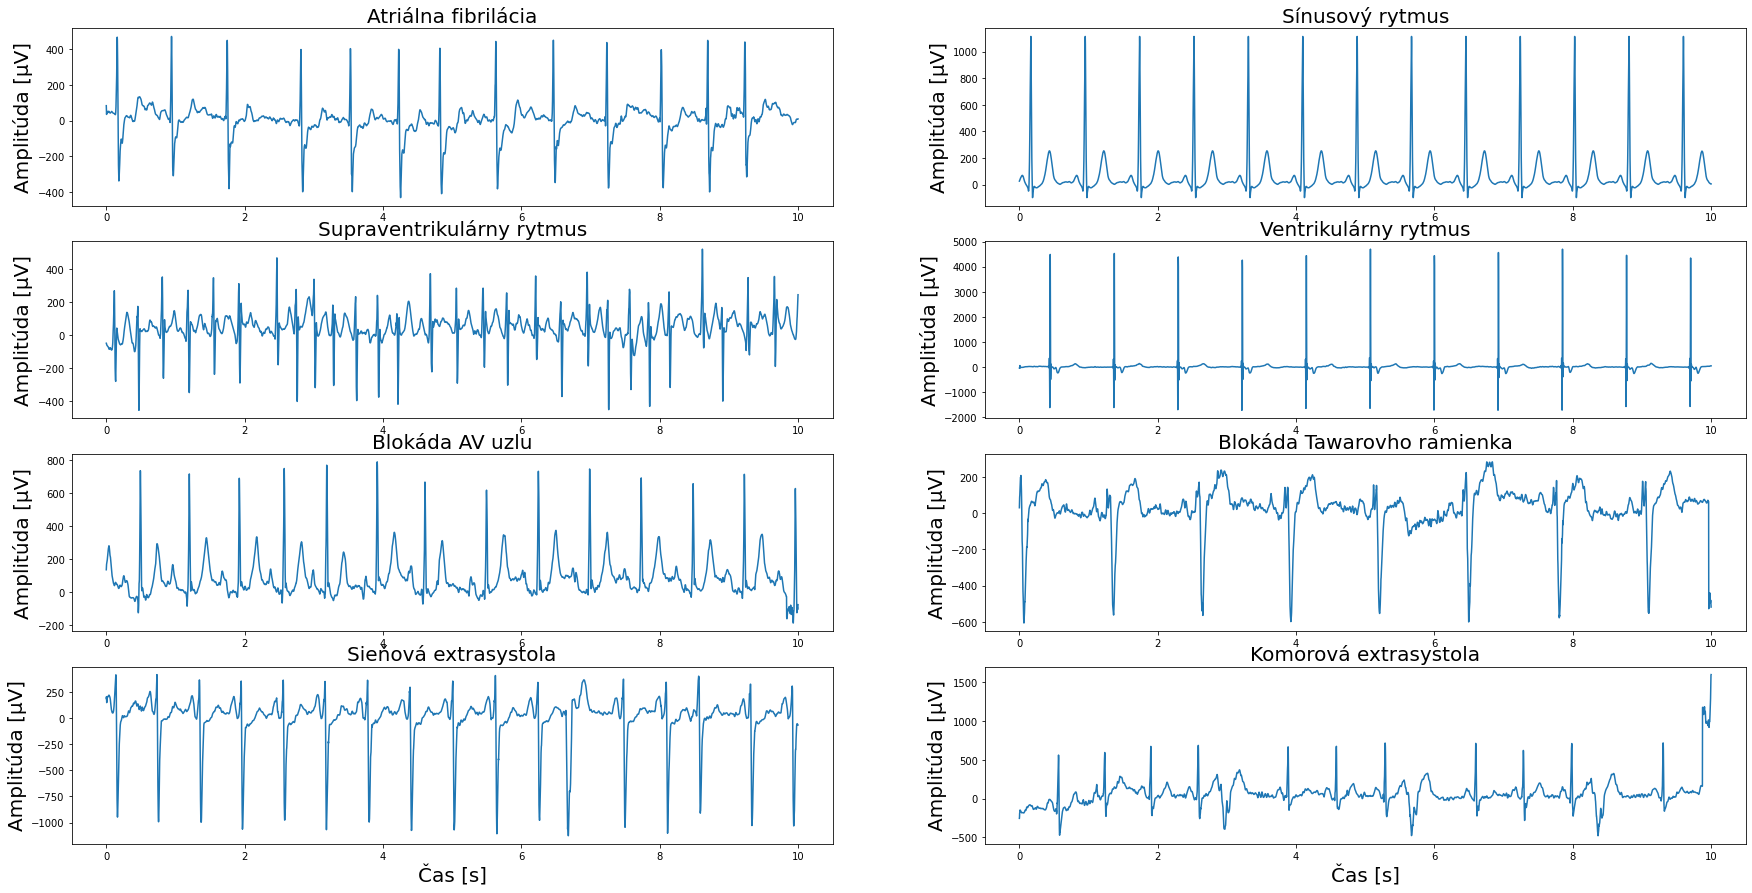

In [0]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,0]))
pyplot.title('Atriálna fibrilácia',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,0]))
pyplot.title('Sínusový rytmus',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,0]))
pyplot.title('Supraventrikulárny rytmus',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,0]))
pyplot.title('Ventrikulárny rytmus',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,0]))
pyplot.title('Blokáda AV uzlu',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,0]))
pyplot.title('Blokáda Tawarovho ramienka',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,0]))
pyplot.title('Sieňová extrasystola',fontsize=20)
pyplot.xlabel('Čas [s]',fontsize=20)
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,0]))
pyplot.title('Komorová extrasystola',fontsize=20)
pyplot.xlabel('Čas [s]',fontsize=20)
pyplot.ylabel('Amplitúda [μV]',fontsize=20)


##AvR

Text(0, 0.5, 'Amplitude [μV]')

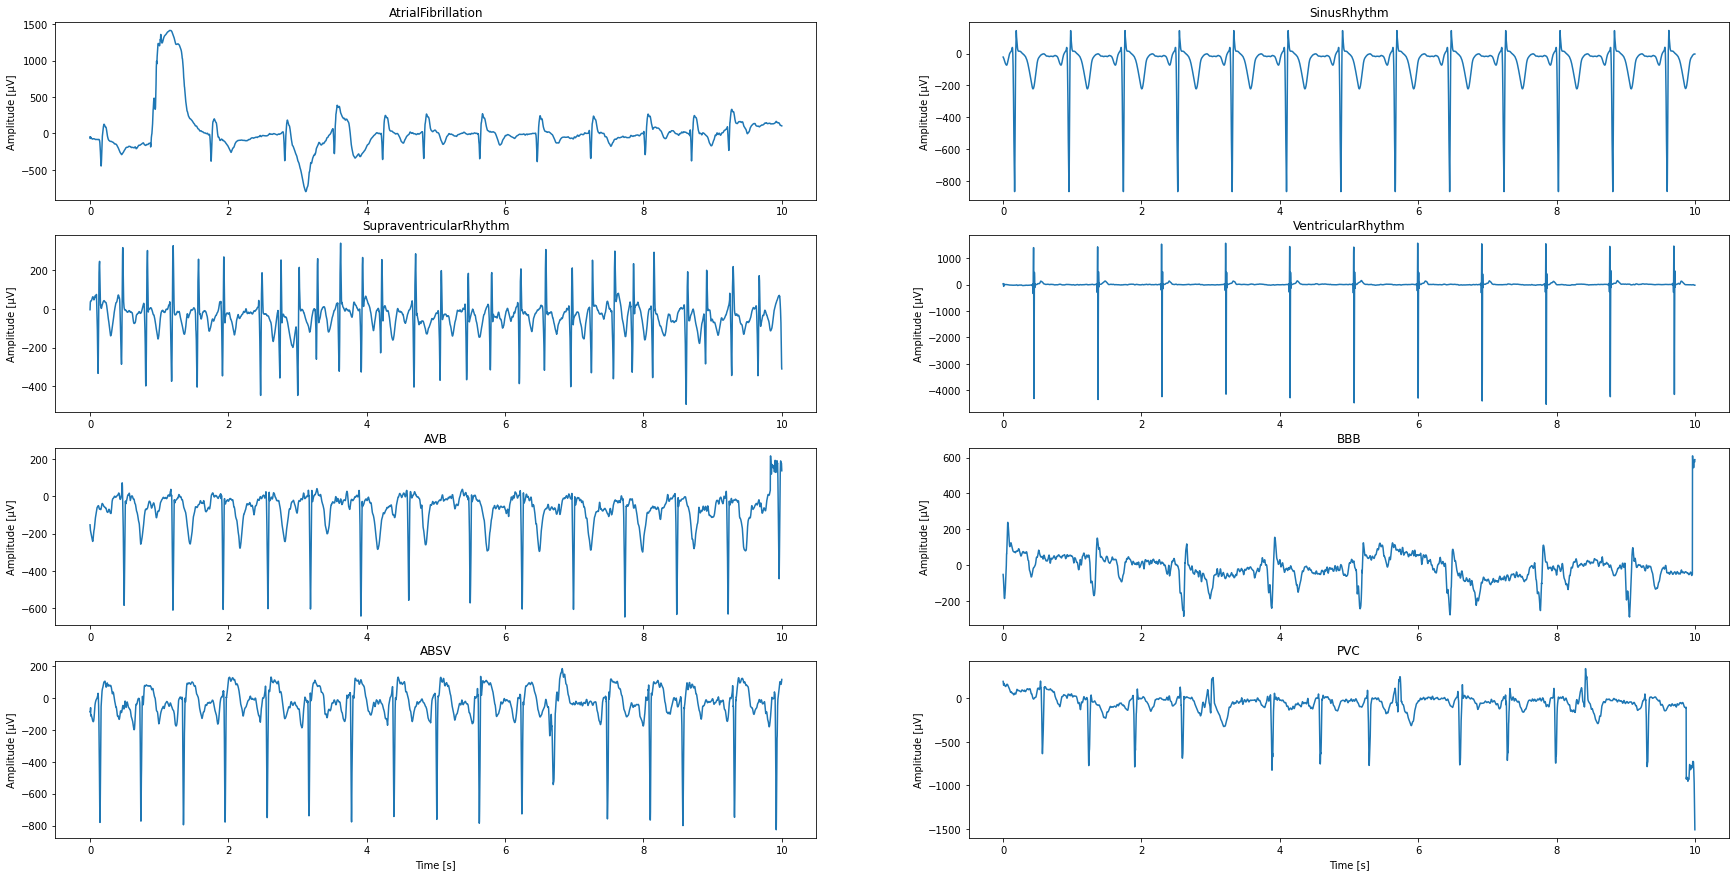

In [0]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,1]))
pyplot.title(labels_names[0])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,1]))
pyplot.title(labels_names[1])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,1]))
pyplot.title(labels_names[2])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,1]))
pyplot.title(labels_names[3])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,1]))
pyplot.title(labels_names[5])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,1]))
pyplot.title(labels_names[6])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,1]))
pyplot.title(labels_names[7])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,1]))
pyplot.title(labels_names[8])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')



##avL

numpy.ndarray

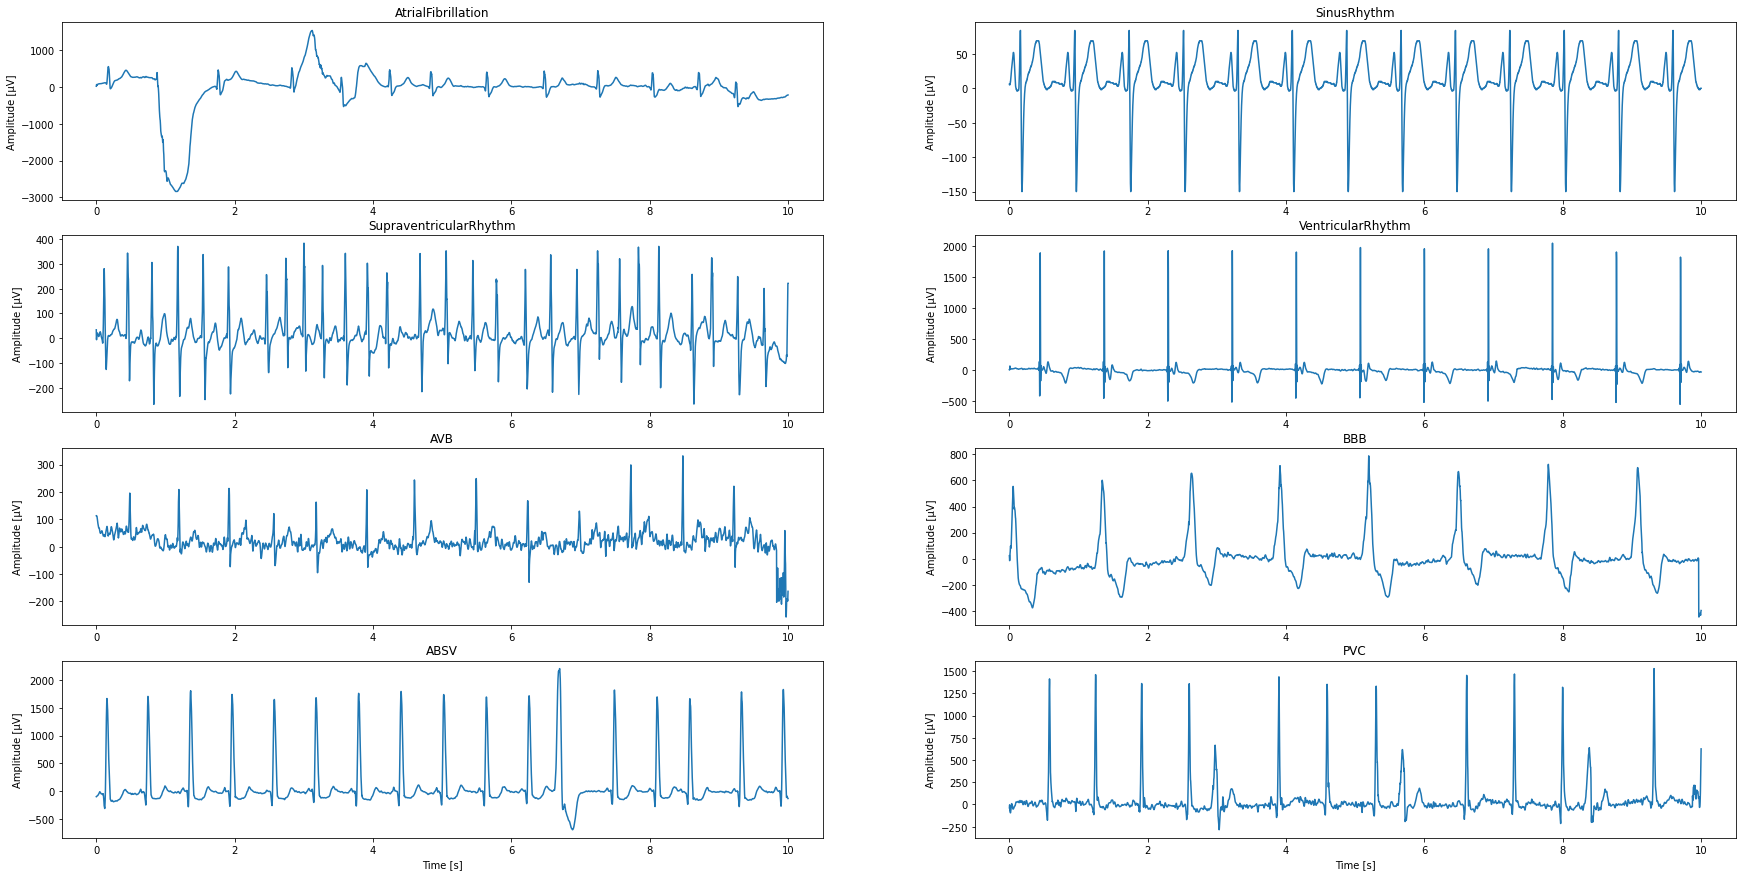

In [0]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,2]))
pyplot.title(labels_names[0])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,2]))
pyplot.title(labels_names[1])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,2]))
pyplot.title(labels_names[2])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,2]))
pyplot.title(labels_names[3])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,2]))
pyplot.title(labels_names[5])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,2]))
pyplot.title(labels_names[6])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,2]))
pyplot.title(labels_names[7])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,2]))
pyplot.title(labels_names[8])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')

type(AF2_signal[:,0])


## Signal loading example

In [0]:
AF2_II=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_II.append(signal[:,0])

AF2_II=np.asarray(AF2_II)

print(np.shape(AF2_II))

AF2_avR=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_avR.append(signal[:,1])

AF2_avR=np.asarray(AF2_avR)
print(np.shape(AF2_avR))

AF2_avL=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_avL.append(signal[:,2])

AF2_avL=np.asarray(AF2_avL)

print(np.shape(AF2_avL))

labels=np.ones((len(AF2),1))

print(np.shape(labels))

(267, 5000)
(267, 5000)
(267, 5000)
(267, 1)


##Saving sinus signals

In [0]:
# load real samples of sinus rhythm
SI2_II=[]
for i in range(len(SI2)):
  SI2_PATH=SINUS_PATH / SI2[i]
  signal=sio.loadmat(SI2_PATH)
  signal=signal['data']
  SI2_II.append(signal[:,0])

SI2_II=np.asarray(SI2_II)
print(np.shape(SI2_II))
np.save(WORKDIR_PATH / "SI2_II_full",SI2_II)


(3350, 5000)


# **Electrocardiogram generation with a bidirectional LSTM-CNN generative adversarial network**
http://www.nature.com/articles/s41598-019-42516-z


### Signal loading arameters

In [0]:
# which signals to load

#subor= "SI2_II.npy"     # start signaly - 3120 samples from start (0-3120)
#subor="SI2_II_end.npy"  # end signaly - 3120 samples till end (1880-5000)
subor="SI2_II_full.npy"  # full signaly - all 5000 samples (0-5000)

## Preprocessing the input data
* Delete signals that does not fall into range [-1500, 2000]
* Clip them to range [1200, 1200] - easily normalized after
* Normalize inputs to the range [-1, 1] and use tanh in the generator output.

In [0]:
#odstranenie nevhodných signálov
clip_value_top=2000
clip_value_bottom=1500

#orezanie signálov
clip_value_top2=1200
clip_value_bottom2=1200

# vzorkovacia frekvenica (aku chceme)
fvz=360 #500 

In [8]:
SI2_II=np.load(WORKDIR_PATH / subor)
SI2_II=np.transpose(SI2_II)
SI2_II=SI2_II.astype('float32') 

print('Data type of SI2 ->          ' + str(SI2_II.dtype))
print('Type of SI2 ->               ' + str(type(SI2_II)))
print('Shape of SI2 ->              ' + str(np.shape(SI2_II)))

#prevzorkovanie signalu

resampled_signals_360=[]
for i in range(SI2_II.shape[1]):
	resampled_signals_360.append(scipy.signal.resample(SI2_II[:,i],3600))
resampled_signals_360=np.asarray(resampled_signals_360)
resampled_signals_360=np.transpose(resampled_signals_360)

print('Signal resampled from 500Hz to 360Hz ->              ' + str(np.shape(resampled_signals_360)))

#skratenie signalu

SI2_II=resampled_signals_360[479:3599,:]
print('Signal shortened from 3600 to 3120 samples ->              ' + str(np.shape(SI2_II)))

number_of_signals = SI2_II.shape[1]
length_of_signal = SI2_II.shape[0]

print('Clip value top of SI2 ->         ' + str(clip_value_top) + 'μV')
print('Clip value bottom of SI2 ->      ' + str(clip_value_bottom) + 'μV')

# orezanie signalov

idx=[]
for i in range (number_of_signals):
  for j in range(length_of_signal):
    if SI2_II[j,i] > clip_value_top:
      idx.append(i)
    elif SI2_II[j,i] < (-clip_value_bottom):
      idx.append(i)

clipped_signals_idx=np.unique(idx)
print('Number of clipped signals -> ' + str(len(clipped_signals_idx)))

SI2_II=np.delete(SI2_II,clipped_signals_idx[:],1)
print('These signals were deleted.')

number_of_signals = SI2_II.shape[1]
length_of_signal = SI2_II.shape[0]
time_axis=np.linspace(0,length_of_signal/fvz,length_of_signal)

print('Clip value top of SI2 ->         ' + str(clip_value_top2) + 'μV')
print('Clip value bottom of SI2 ->      ' + str(clip_value_bottom2) + 'μV')

idx=[]
for i in range (number_of_signals):
  for j in range(length_of_signal):
    if SI2_II[j,i] > clip_value_top2:
      SI2_II[j,i]= clip_value_top2
      idx.append(i)
    elif SI2_II[j,i] < (-clip_value_bottom2):
      SI2_II[j,i]= -clip_value_bottom2
      idx.append(i)

print('Number of SI2 signals ->     ' + str(number_of_signals))
print('Length of SI2 signals ->     ' + str(length_of_signal))
print('Time axis :')
print(time_axis)
print('Time axis length is :' + str(len(time_axis)))
print('Max of SI_II_11 :' + str(np.amax(SI2_II)))
print('Min of SI_II_11 :' + str(np.amin(SI2_II)))

# transformacia dat

SI2_II_zscore=scipy.stats.zscore(SI2_II)
SI2_II_01=(SI2_II - np.amin(SI2_II)) / (np.amax(SI2_II) - np.amin(SI2_II))
SI2_II_11=(SI2_II)/clip_value_top2 #1200

print('Shape of Z_score normalization ->     ' + str(np.shape(SI2_II_zscore)))
print('Shape of 01 normalization ->          ' + str(np.shape(SI2_II_01)))
print('Shape of 11 normalization ->          ' + str(np.shape(SI2_II_11)))  

print('Range of Z_score normalization ->     ' + '[' + str(np.amin(SI2_II_zscore)) + ',' + str(np.amax(SI2_II_zscore))+ ']' )
print('Range of 01 normalization ->          ' + '[' + str(np.amin(SI2_II_01)) + ',' + str(np.amax(SI2_II_01))+ ']' )
print('Range of 11 normalization ->          ' + '[' + str(np.amin(SI2_II_11)) + ',' + str(np.amax(SI2_II_11))+ ']' )  

# noisy

noisy_signals=[]
pure = np.linspace(-1, 1, SI2_II.shape[0])
noise = np.random.normal(0, 0.1, pure.shape)
for i in range(SI2_II.shape[1]):
	noisy_signals.append(SI2_II_11[:,i] + noise)
noisy_signals=np.asarray(noisy_signals)
noisy_signals=noisy_signals.reshape(SI2_II.shape[0],SI2_II.shape[1])

print('Range of noisy signals ->          ' + '[' + str(np.amin(noisy_signals)) + ',' + str(np.amax(noisy_signals))+ ']' )  
print('Shape of noisy_signals ->              ' + str(np.shape(noisy_signals)))


Data type of SI2 ->          float32
Type of SI2 ->               <class 'numpy.ndarray'>
Shape of SI2 ->              (5000, 3350)
Signal resampled from 500Hz to 360Hz ->              (3600, 3350)
Signal shortened from 3600 to 3120 samples ->              (3120, 3350)
Clip value top of SI2 ->         2000μV
Clip value bottom of SI2 ->      1500μV
Number of clipped signals -> 55
These signals were deleted.
Clip value top of SI2 ->         1200μV
Clip value bottom of SI2 ->      1200μV
Number of SI2 signals ->     3295
Length of SI2 signals ->     3120
Time axis :
[0.00000000e+00 2.77866838e-03 5.55733675e-03 ... 8.66110933e+00
 8.66388800e+00 8.66666667e+00]
Time axis length is :3120
Max of SI_II_11 :1200.0
Min of SI_II_11 :-1200.0
Shape of Z_score normalization ->     (3120, 3295)
Shape of 01 normalization ->          (3120, 3295)
Shape of 11 normalization ->          (3120, 3295)
Range of Z_score normalization ->     [-8.92911,10.876356]
Range of 01 normalization ->          [0.0,1.0

## Discriminator

* The sequence comprising ECG data points can be regarded as a time series sequence (a normal image requires both a vertical convolution and a horizontal convolution) rather than an image, so only one-dimensional **(1-D) convolution** need to be involved.

* We assume that an input sequence x1, x2, … xT comprises T points, where each is represented by a d-dimensional vector.
 * teda 3120 bodov, kazdy z nich je reprezentoavany jednym bodom v 5D (laten_dim) 
 * input_shape=(None,3120,5) v generatore (None,3120,1) v diskriminatore

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 601, 10)           1210      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 601, 10)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 186, 10)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 51, 5)             1805      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 51, 5)             0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 5)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)               

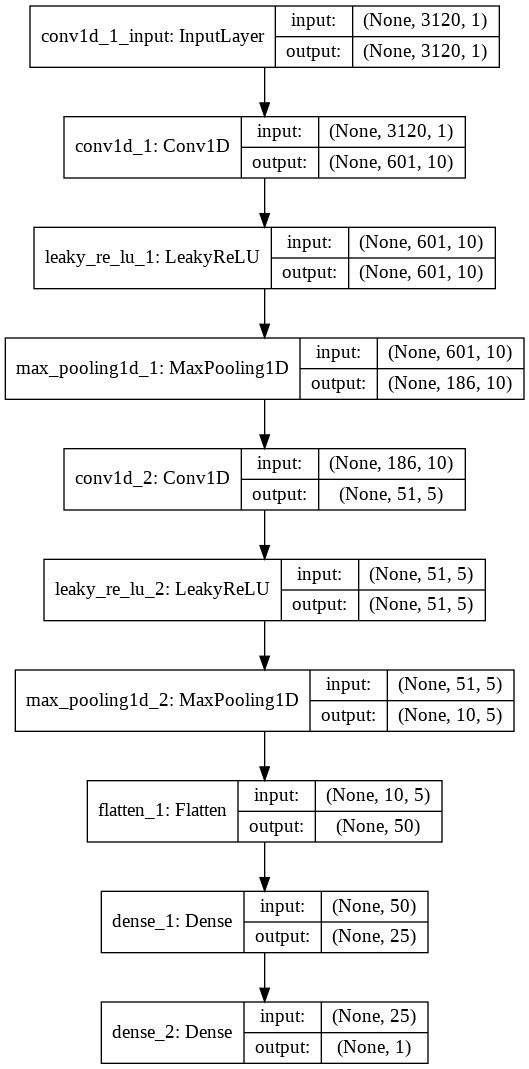

In [9]:
def define_discriminator(input_shape=(3120,1)):
  model = Sequential()
  model.add(Conv1D(input_shape=(3120,1),filters=10, kernel_size=120, strides=5, padding='valid',kernel_initializer='he_normal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling1D(pool_size=46, strides=3, padding='valid', data_format='channels_last'))
  model.add(Conv1D(filters=5, kernel_size=36, strides=3, padding='valid'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling1D(pool_size=24, strides=3, padding='valid', data_format='channels_last'))
  model.add(Flatten())
  model.add(Dense(25))
  model.add(Dense(1,activation='sigmoid'))
  # optimalizacny algoritmus
  #adam_D = Adam(lr=0.0002, beta_1=0.5)
  #sgd_D = SGD(lr=0.001) 
  #sgd_D = SGD(lr=0.0001) 
  sgd_D = SGD(lr=0.00001)
  model.compile(loss='binary_crossentropy', optimizer=sgd_D, metrics=['accuracy'])
  return model

# zostavenie diskriminátoru
discriminator_model = define_discriminator()


# summarize the model
discriminator_model.summary()
# plot the model
plot_model(discriminator_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

# model.add(Conv1D(input_shape=(3120,1),filters=10, kernel_size=120, strides=5, padding='valid', data_format='channels_last', dilation_rate=1, 
#                  activation=None, use_bias=True, kernel_initializer='he_normal', bias_initializer='zeros', kernel_regularizer=None, 
#                  bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
#model.add(BatchNormalization())

# model.add(Conv1D(filters=5, kernel_size=36, strides=3, padding='valid', data_format='channels_last', dilation_rate=1, 
#                  activation=None, use_bias=True, kernel_initializer='he_normal', bias_initializer='zeros', 
#                  kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))

#NOTES:

# BCEWithLogitsLoss() and Sigmoid() doesn't work together, because BCEWithLogitsLoss() includes the Sigmoid activation. 
# So you can use BCEWithLogitsLoss() without Sigmoid() or you can use Sigmoid() and BCELoss()

# OPTIMALIZATION OPTIONS:

# 0 inicializacia
# 1 Use label smoothing in the discriminator, with small random noise.  
# 2 Add random noise to the labels in the discriminator.
# 3 Add noise to inputs to the discriminator and decay the noise over time.
# 4 Optimalizer / paper= SGD a mini-batch o dlzke 100 / adam je v GANoch standart
#   sgd = SGD(lr=0.00001)
#   adam = Adam(lr=0.0002, beta_1=0.5)
# 5 Remove Fully-Connected Layers
# 6 Use ReLU, Leaky ReLU, and Tanh
# 7 Kernel size, filters, strides

## Generator

*  series of noise data points that follow a Gaussian distribution are fed into the generator as a fixed length sequence. We assume that each noise point can be represented as a d-dimensional **?one-hot vector?** and the length of the sequence is T. Thus, the size of the input matrix is **T × d.** 

* To prevent slow gradient descent due to parameter inflation in the generator, we add a dropout layer and set the probability to 0.5. 

* The generator produces data based on the noise data sampled from a Gaussian distribution, which is **fitted to the real data distribution as accurately as possible.**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=True, activation="tanh", kernel_initializer="glorot_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 3120, 100)         160800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 3120, 100)         160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3120, 100)         0         
_________________________________________________________________
dense_3 (Dense)              (None, 3120, 1)           101       
Total params: 321,701
Trainable params: 321,701
Non-trainable params: 0
_________________________________________________________________


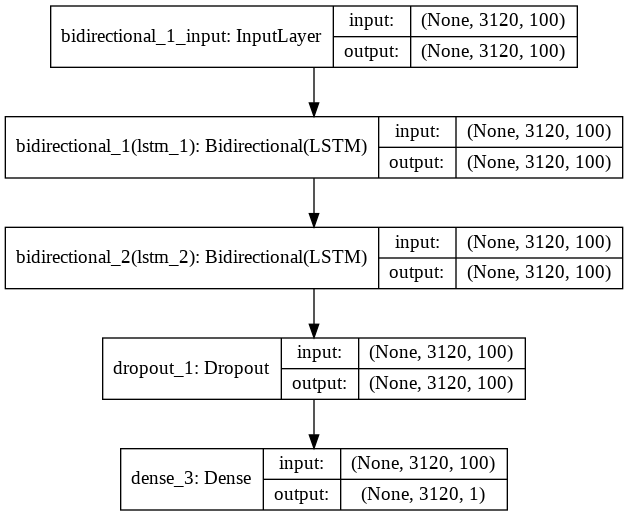

In [10]:
def define_generator(latent_dim):
  model = Sequential()
  model.add(Bidirectional(LSTM(100, return_sequences=True,init='glorot_normal',activation='tanh'), 
                          input_shape=(3120,latent_dim), merge_mode='sum'))
  #model.add(LeakyReLU(alpha=0.2))
  model.add(Bidirectional(LSTM(100, return_sequences=True,activation='tanh'),merge_mode='sum'))
  #model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='tanh'))
  return model

# veľkosť latentného priestoru
latent_dim =5
# zostavenie generátoru
generator_model = define_generator(latent_dim)



# summarize the model
generator_model.summary()
# plot the model
plot_model(generator_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

# model.add(Bidirectional(LSTM(100, activation='tanh', recurrent_activation='tanh', use_bias=True, kernel_initializer='random_normal', 
# recurrent_initializer='zeros', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
# bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
# recurrent_dropout=0.0, implementation=2, return_sequences=True, 
# return_state=False, go_backwards=False, stateful=False, unroll=False),input_shape=(3120,latent_dim), merge_mode='sum'))
# return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

#model.add(Bidirectional(LSTM(100, activation='tanh', recurrent_activation='tanh', use_bias=True, kernel_initializer='random_normal', 
#recurrent_initializer='zeros', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
#bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
#recurrent_dropout=0.0, implementation=2, return_sequences=True, 
#return_state=False, go_backwards=False, stateful=False, unroll=False),merge_mode='sum'))

#latent space method 2

#model.add(Dense(3120*latent_dim, input_dim=latent_dim))
#model.add(LeakyReLU(alpha=0.2))
#model.add(Reshape((3120, latent_dim)))
#model.add(Bidirectional(LSTM(100, return_sequences=True,input_shape=(3120,latent_dim)), merge_mode='sum')) # input_shape=(batch_size,3120,latent_dim)

# NOTES:

# 1 Return sequences - TRUE
# 2 Use dropout of 50 percent during train and generation. - ALREADY USING
# 3 Normalize inputs to the range [-1, 1] and use tanh in the generator output. - DONE
# 4 LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
#   It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. ” alebo [-1,1] ak mam tanh

# OPTIMALIZATION OPTIONS:

# 1 Use Leaky ReLU in the generator and discriminator.
# 2 The best practice for DCAGAN models reported in the paper is to initialize all weights using 
#   a zero-centered Gaussian distribution (the normal or bell-shaped distribution) with a standard deviation of 0.02.

## Possible tuning


### https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

### TIPS AND TRICKS:

*   Add random noise to the labels in the discriminator.
*   Add noise to inputs to the discriminator and decay the noise over time.

### ALREADY TRIED:

*   Use label smoothing in the discriminator, with small random noise.**DONE**
*   Use labels if you have them.**DONE**
*   Use dropout of 50 percent during train and generation. **DONE**
*   Normalize inputs to the range [-1, 1] and use tanh in the generator output. - **DONE**
*   Flip the labels and loss function when training the generator. - **DONE**
*   Sample Gaussian random numbers as input to the generator. - **DONE**
*   Use Leaky ReLU in the generator and discriminator. **DONE**
*   Use Average pooling and stride for downsampling; use ConvTranspose2D and stride for upsampling. **MAX POOLING, CONV1D**



## Generating fake and real signals



Mean of SI2_II_11_mean :
0.5305389
Std of SI2_II_11_mean :
0.06133917
Latent space points shape:
(5, 3120, 100)
Latent space 5 dimensions, 3120 samples : 
[[[0.54527247 0.56894389 0.59244855 ... 0.63244968 0.5818359  0.6450435 ]
  [0.65763215 0.52432888 0.51537553 ... 0.58287427 0.55913599 0.49636406]
  [0.60992293 0.49781475 0.43643932 ... 0.59741015 0.54154957 0.59630088]
  ...
  [0.51012798 0.52728239 0.5630862  ... 0.57933293 0.58669073 0.64527751]
  [0.60892718 0.54113872 0.57910637 ... 0.55071202 0.50901666 0.52282111]
  [0.61463292 0.4624774  0.57575228 ... 0.50431877 0.55112541 0.47322789]]

 [[0.5144906  0.40886748 0.52008644 ... 0.61302105 0.62851587 0.47753869]
  [0.48896207 0.55807135 0.43504384 ... 0.5316321  0.53174774 0.51033702]
  [0.53493885 0.55869331 0.53015376 ... 0.49961308 0.56087712 0.48589939]
  ...
  [0.64121066 0.49086809 0.53110426 ... 0.47598248 0.5337085  0.4841005 ]
  [0.52215065 0.42510922 0.45686715 ... 0.52880756 0.57789036 0.55382299]
  [0.70370568 0.5

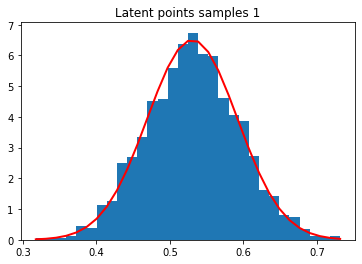

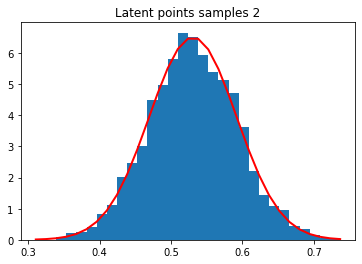

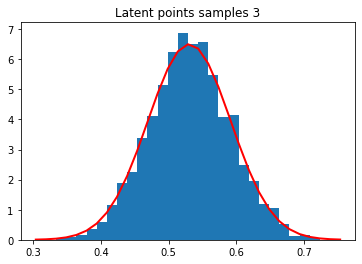

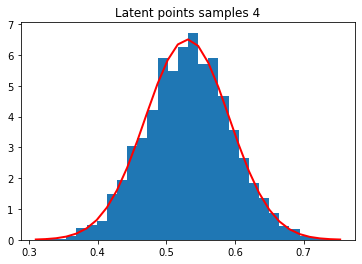

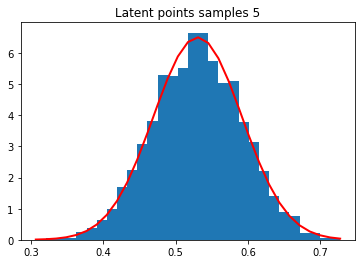

Fake data points shape:
(5, 3120, 1)
Fake data  points [0]:
[0.19043027 0.24191552 0.2938249  ... 0.57167155 0.5371969  0.49221188]


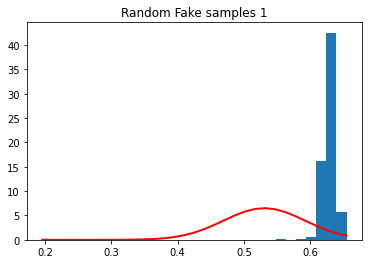

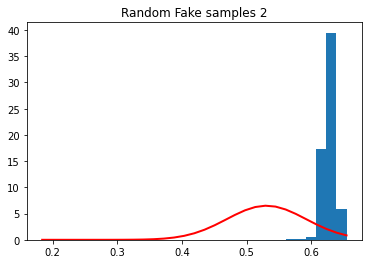

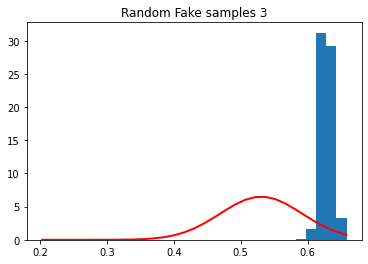

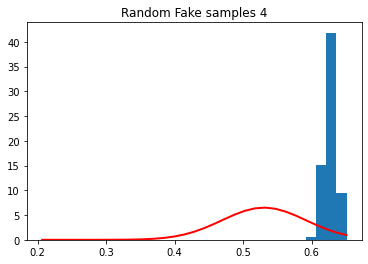

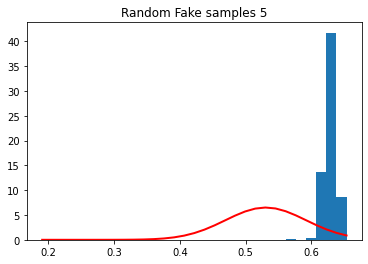

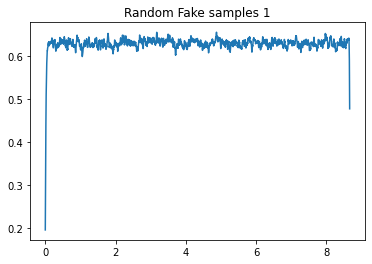

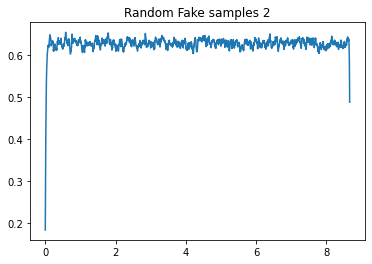

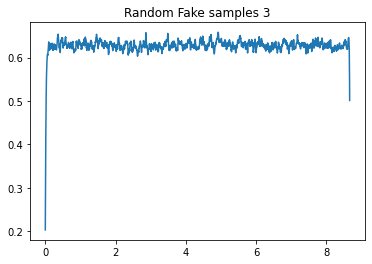

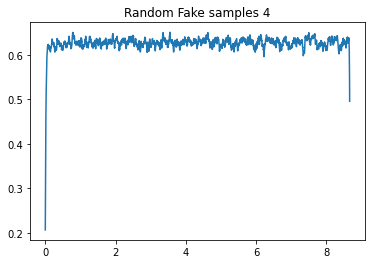

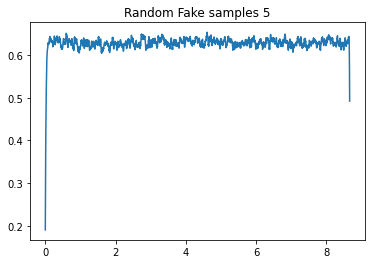

Real data points shape:
(5, 3120, 1)
Real data  points [0]:
[[0.49654502]
 [0.49595046]
 [0.49621785]
 ...
 [0.4954181 ]
 [0.5018585 ]
 [0.49634653]]
Length of Real data  points [0]:
3120


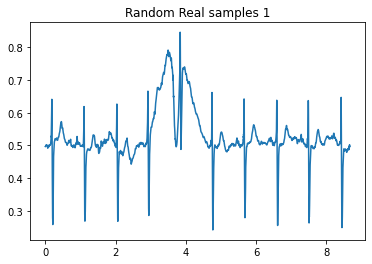

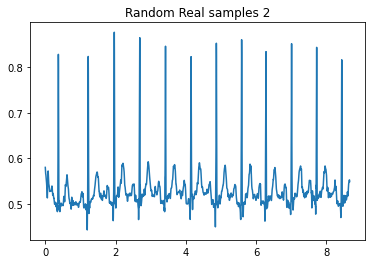

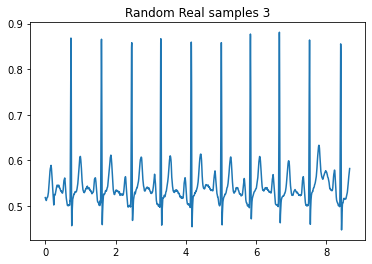

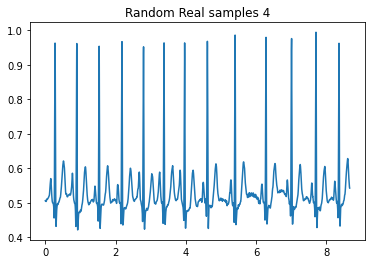

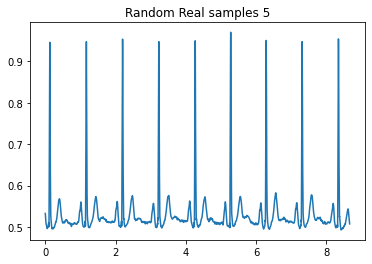

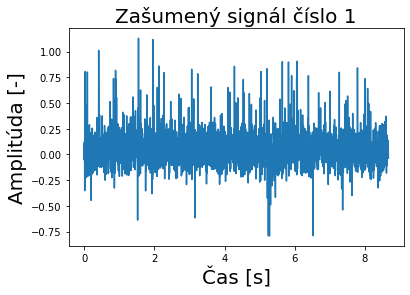

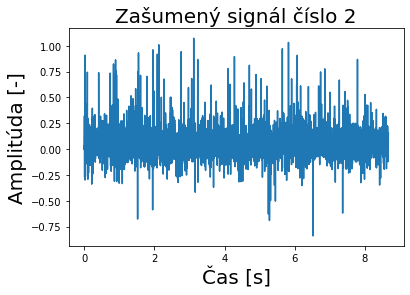

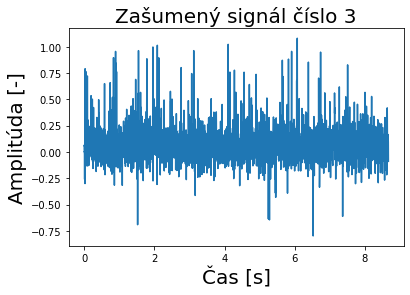

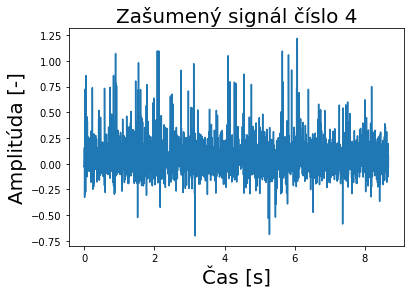

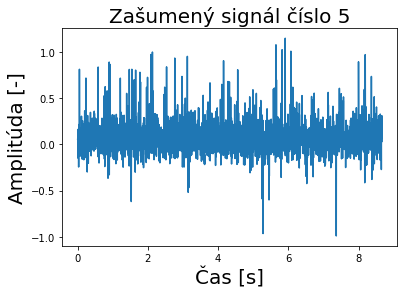

In [12]:
# generovanie latentnych bodov

def generate_latent_points(latent_dim,batch_size,mu,sigma):
  latent_points = np.random.normal(mu,sigma, size=(3120 * latent_dim * batch_size))
  latent_points=latent_points.reshape(batch_size,length_of_signal,latent_dim) #batch x 3120 x 5
  return latent_points


# generovanie falosnych signalov

def generate_fake_samples(generator, latent_dim, batch_size,mu,sigma):
  # generovanie latentnych bodov
  X = generate_latent_points(latent_dim, batch_size,mu,sigma)
  x_input = generator_model.predict(X)
  # label smoothing - intervalove oznacenia skupin
  label=[]
  for i in range(batch_size):
    y = np.round(random.uniform(0, 0.1),2)
    label.append(y)
  label=np.asarray(label)
  y=label.reshape(batch_size,1)
  #y = np.zeros((batch_size,1))
  return x_input,y

# generovanie realnych signalov

def generate_real_samples(batch_size,signal):
  label=[]
  X=[]
  #nahodne cislo signalu
  for i in range (batch_size):
    cislo_signalu=random.randint(0, signal.shape[1]-1)
    X.append(signal[:,cislo_signalu])
  X=np.asarray(X)
  X=X.reshape(batch_size,length_of_signal,1)

  # label smoothing - intervalove oznacenia skupin
  for i in range(batch_size):
    y = np.round(random.uniform(0.9, 1),2)
    label.append(y)
  label=np.asarray(label)
  y=label.reshape(batch_size,1)
  #y = np.ones((batch_size,1))
  return X,y 

# statistiky signalu pre specificke rozlozenie
SI2_II_11=SI2_II_01

SI2_II_11_mean=np.mean(np.mean(SI2_II_11, axis=0))
SI2_II_11_std=np.std(SI2_II_11)
time_axis=np.linspace(0,length_of_signal/360,length_of_signal)

print('Mean of SI2_II_11_mean :')
print(SI2_II_11_mean)
print('Std of SI2_II_11_mean :')
print(SI2_II_11_std)  

latent_points=generate_latent_points(latent_dim=100,batch_size=5,mu=SI2_II_11_mean,sigma=SI2_II_11_std)
print('Latent space points shape:')
print(np.shape(latent_points))
print('Latent space 5 dimensions, 3120 samples : ')
print(latent_points)

#plot latent points

for i in range(5): 
  count, bins, ignored = plt.hist(latent_points[i][:,0], 30, density=True)
  plt.plot(bins, 1/(SI2_II_11_std * np.sqrt(2 * np.pi))*np.exp( - (bins - SI2_II_11_mean)**2 / (2 * SI2_II_11_std**2) ), linewidth=2, color='r')
  pyplot.title('Latent points samples'+ ' '+ str(i+1))
  plt.show()

# falosne signaly

fake_data,y = generate_fake_samples(generator_model, latent_dim=100,batch_size=5, mu=SI2_II_11_mean, sigma=SI2_II_11_std)

print('Fake data points shape:')
print(np.shape(fake_data))
print('Fake data  points [0]:')
print(fake_data[i][:,0])

# plot rozlozenia falosnych signalov

for i in range(5): 
  count, bins, ignored = plt.hist(fake_data[i][:,0], 30, density=True)
  plt.plot(bins, 1/(SI2_II_11_std * np.sqrt(2 * np.pi))*np.exp( - (bins - SI2_II_11_mean)**2 / (2 * SI2_II_11_std**2) ), linewidth=2, color='r')
  pyplot.title('Random Fake samples'+ ' '+ str(i+1))
  plt.show()

# plot falosnych signalov

for i in range(5): 
  # plot samples
  plt.plot(time_axis, fake_data[i][:,0])
  pyplot.title('Random Fake samples'+ ' '+ str(i+1)) 
  pyplot.show()

# realne signaly

real_data,y = generate_real_samples(5,SI2_II_11)

print('Real data points shape:')
print(np.shape(real_data))
print('Real data  points [0]:')
print(real_data[0])
print('Length of Real data  points [0]:')
print(len(real_data[0]))

# plot realnych signalov

for i in range(5): 
  plt.plot(time_axis, real_data[i])
  pyplot.title('Random Real samples'+ ' '+ str(i+1)) 
  pyplot.show()

# zasumene signaly

for i in range(5): 
  plt.plot(time_axis, noisy_signals[:,i])
  pyplot.title('Zašumený signál číslo'+ ' '+ str(i+1),fontsize=20) 
  pyplot.xlabel('Čas [s]',fontsize=20)
  pyplot.ylabel('Amplitúda [-]',fontsize=20) 
  pyplot.show()

### As the generator has not been trained, the generated points are complete rubbish, as we expect, but we can imagine that as the model is trained, these points will slowly begin to resemble signal.

## Testing the discriminator

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

Therefore, in GAN cases, you don't want D loss to go to zero because that would mean that D is doing a too good job (and most importantly, G a too bad one), ie it can easily discriminate between fake and real data (ie G's creations are not close enough to real data).

In [13]:
start = timer()

# vytvorenie trenovacej a testovacej databazy 80/20 
number_of_train_signals=int(np.round(number_of_signals*0.8))
SI2_II_11_train=SI2_II_11[:,0:number_of_train_signals]
SI2_II_11_test=SI2_II_11[:,number_of_train_signals:number_of_signals]

print('Shape of TRAIN SI2 signals->     ' + str(np.shape(SI2_II_11_train)))
print('Shape of TEST SI2 signals ->     ' + str(np.shape(SI2_II_11_test)))
print('Shape of NOISY SI2 signals ->     ' + str(np.shape(noisy_signals)))
	
# testovanie diskriminatora

def test_discriminator(model,train_signals,test_signals,SI2_II_11_mean,SI2_II_11_std, n_iters, batch_size):

	half_batch = int(batch_size / 2)
 
	for i in range(n_iters):

		# realne signaly
		x_real_train, y_real_train = generate_real_samples(half_batch,train_signals)   #50 train real
		x_real_test, y_real_test = generate_real_samples(half_batch,test_signals)			 #50 test real

		# trening diskriminatora
		train_loss, train_acc = model.train_on_batch(x_real_train, y_real_train)
	
		# falosne zasumene signaly
		x_fake,_=generate_real_samples(half_batch,noisy_signals)	#50 noisy
		_, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch, SI2_II_11_mean, SI2_II_11_std) #oznacenia chceme fake=0

		# # falosne signaly z generatoru
		# x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch, SI2_II_11_mean, SI2_II_11_std)		 #50 fake 

		# update discriminator on fake/noisy samples
		loss_fake, fake_acc = model.train_on_batch(x_fake, y_fake)
	
		print('>%d train_acc=%.0f%% fake_acc=%.0f%% 		train_loss=%f fake_loss=%f' % (i+1, train_acc*100, fake_acc*100, train_loss, loss_fake))
		train_acc_graph.append(train_acc)
		train_loss_graph.append(train_loss)
		fake_acc_graph.append(fake_acc)
		loss_fake_graph.append(loss_fake)


train_acc_graph=[]
fake_acc_graph=[]
train_loss_graph=[]
loss_fake_graph=[]

# vytvorenie diskriminatoru
discriminator_model = define_discriminator(input_shape=(3120,1))
# testovanie diskriminatoru
test_discriminator(discriminator_model,SI2_II_11_train,SI2_II_11_test,SI2_II_11_mean,SI2_II_11_std, 200, 200)

end = timer()
print('Time of training:') 
print(end - start) #1911.7685786840002=31 MINUT, #1621.347090326 200 iteracii

np.save(WORKDIR_PATH / "train_acc_graph_sgd3",train_acc_graph)
np.save(WORKDIR_PATH / "fake_acc_graph_sgd3",fake_acc_graph)
np.save(WORKDIR_PATH / "train_loss_graph_sgd3",train_loss_graph)
np.save(WORKDIR_PATH / "loss_fake_graph_sgd3",loss_fake_graph)


Shape of TRAIN SI2 signals->     (3120, 2636)
Shape of TEST SI2 signals ->     (3120, 659)
Shape of NOISY SI2 signals ->     (3120, 3295)
>1 train_acc=5% fake_acc=1% 		train_loss=0.644350 fake_loss=0.766594
>2 train_acc=5% fake_acc=2% 		train_loss=0.580402 fake_loss=0.741470
>3 train_acc=8% fake_acc=0% 		train_loss=0.532463 fake_loss=0.740200
>4 train_acc=5% fake_acc=2% 		train_loss=0.490796 fake_loss=0.721328
>5 train_acc=4% fake_acc=2% 		train_loss=0.469171 fake_loss=0.694218
>6 train_acc=3% fake_acc=3% 		train_loss=0.439145 fake_loss=0.672720
>7 train_acc=8% fake_acc=4% 		train_loss=0.420212 fake_loss=0.648756
>8 train_acc=9% fake_acc=3% 		train_loss=0.406625 fake_loss=0.616013
>9 train_acc=2% fake_acc=5% 		train_loss=0.390596 fake_loss=0.594059
>10 train_acc=5% fake_acc=3% 		train_loss=0.374261 fake_loss=0.582185
>11 train_acc=8% fake_acc=5% 		train_loss=0.362375 fake_loss=0.560552
>12 train_acc=3% fake_acc=3% 		train_loss=0.355319 fake_loss=0.538440
>13 train_acc=2% fake_acc=4% 		

### Analyze discriminator performance
* When things are working, D loss has low variance and goes down over time vs having huge variance and spiking
if loss of generator steadily decreases, then it's fooling D with garbage (says martin)


* Therefore, in GAN cases, you don't want D loss to go to zero because that would mean that D is doing a too good job (and most importantly, G a too bad one), ie it can easily discriminate between fake and real data (ie G's creations are not close enough to real data).


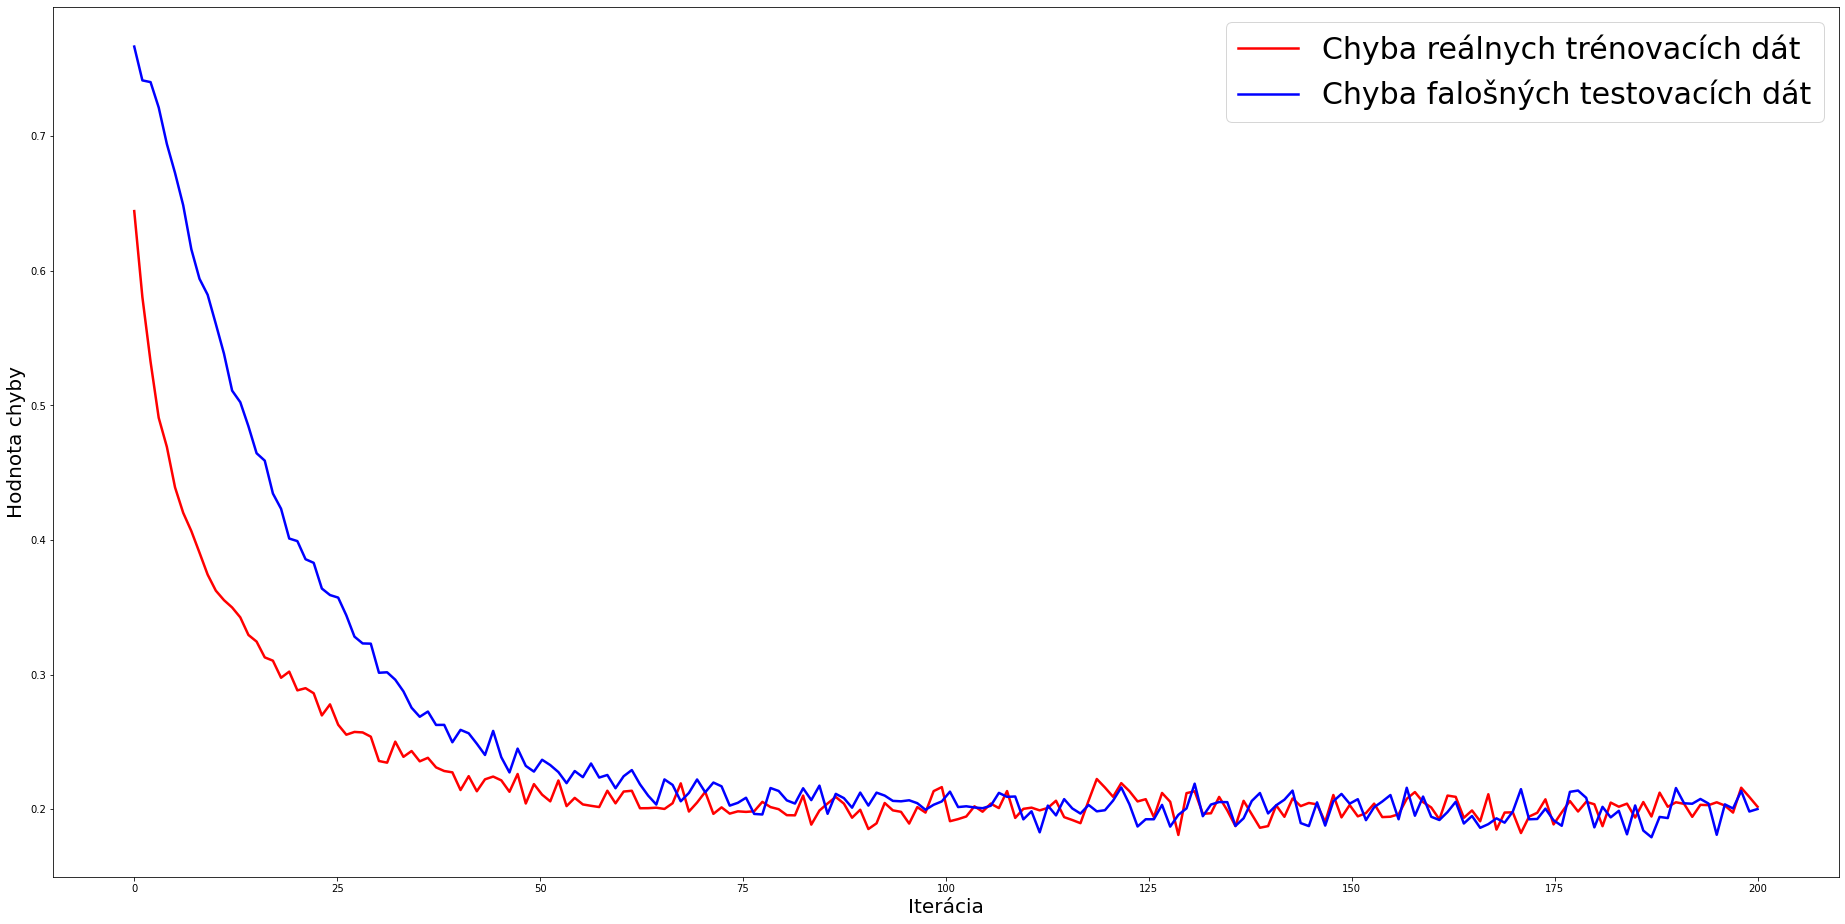

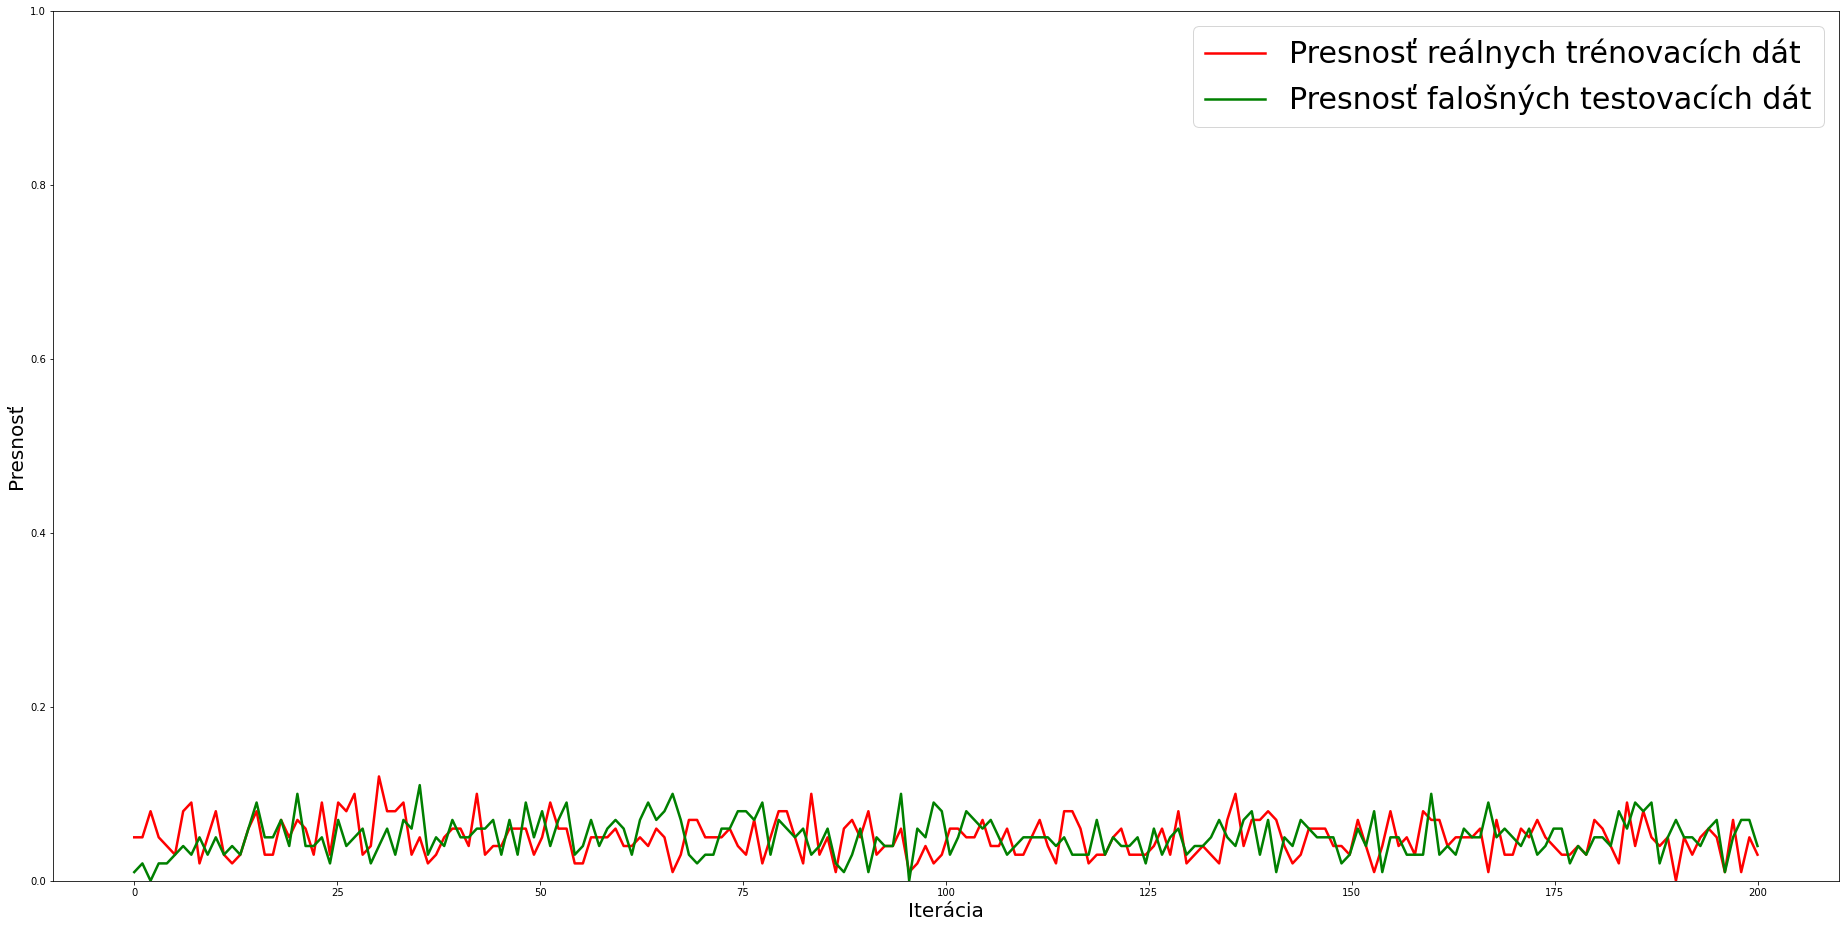

In [14]:
train_acc_graph=np.load(WORKDIR_PATH / "train_acc_graph_sgd3.npy")
fake_acc_graph=np.load(WORKDIR_PATH / "fake_acc_graph_sgd3.npy")

train_loss_graph=np.load(WORKDIR_PATH / "train_loss_graph_sgd3.npy")
loss_fake_graph=np.load(WORKDIR_PATH / "loss_fake_graph_sgd3.npy")

# filtered_acc_real2 = [ item for i,item in enumerate(d_real_acc_graph2) if i%100==0 ]
# filtered_acc_fake2 = [ item for i,item in enumerate(d_fake_acc_graph2) if i%100==0 ]

iterations=int(np.array(np.shape(train_acc_graph)))

time_axis=np.linspace(0,iterations,iterations)
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Chyba reálnych trénovacích dát', 'x': time_axis, 'y': train_loss_graph[:], 'color':'r', 'linewidth':2.5},{'name': 'Chyba falošných testovacích dát', 'x': time_axis, 'y': loss_fake_graph[:], 'color':'b', 'linewidth':2.5}]
for signal in mysignals:
  #ax1 = fig.add_subplot(n, n, 1 + i)
  plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
  #ax1.axis('off')
  plt.legend(loc='upper right',prop={'size': 30})
  plt.xlabel('Iterácia',fontsize=20)
  plt.ylabel('Hodnota chyby',fontsize=20)
 
time_axis=np.linspace(0,200,200)
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Presnosť reálnych trénovacích dát', 'x': time_axis, 'y': train_acc_graph[:], 'color':'r', 'linewidth':2.5},{'name': 'Presnosť falošných testovacích dát', 'x': time_axis, 'y': fake_acc_graph[:], 'color':'g', 'linewidth':2.5}]
for signal in mysignals:
  #ax1 = fig.add_subplot(n, n, 1 + i)
  plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
  #ax1.axis('off')
  #ax1.axis('off')
  plt.legend(loc='upper right',prop={'size': 30})
  plt.xlabel('Iterácia',fontsize=20)
  plt.ylabel('Presnosť',fontsize=20)
  plt.ylim(0,1)

## Submodel for generator training

* Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space, generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

* To be clear, we are not talking about a new third model, just a logical third model that uses the already-defined layers and weights from the standalone generator and discriminator models.

* The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

* When training the generator via this subsumed GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

* We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating plausible fake samples.

Gan model summary :
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 3120, 1)           321701    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 4316      
Total params: 326,017
Trainable params: 321,701
Non-trainable params: 4,316
_________________________________________________________________
Gan model plot: 


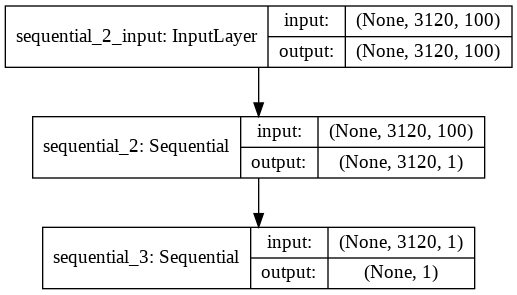

In [15]:
# submodel pre trenovanie generatoru

def define_gan(generator, discriminator):
	# zmrazenie vah diskriminatoru
	discriminator.trainable = False
	# prepojenie modelov
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# optimalizacny algoritmus generatoru
	#adam = Adam(lr=0.0002, beta_1=0.5)
	sgd = SGD(lr=0.001) 
	#sgd = SGD(lr=0.0001) 
	#sgd = SGD(lr=0.00001)
	model.compile(loss='binary_crossentropy', optimizer=sgd)
	return model

# vytvorenie submodelu
gan_model = define_gan(generator_model, discriminator_model)

# summarize gan model
print('Gan model summary :')
gan_model.summary()
# plot gan model
print('Gan model plot: ')
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

## Training GAN - complete model

### Notes from EKG paper:

*  Each model was trained for **500 epochs** with a **mini-batch size of 100**, where the length of the sequence comprised a series of ECG 3120 points and the learning rate was **1 × 10−5.** 

*  The dim for the noise data points was set to **5** and the **length of the generated ECGs was 400.** 

The discriminator model is updated twice per batch, once with real samples and once with fake samples, which is a best practice as opposed to combining the samples and performing a single update.

Finally, we report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate.

Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch. The generator loss is less critical and may hover between 0.5 and 2 or higher.

For example, I came across: Make the discriminator much less expressive by using a smaller model. Generation is a much harder task and requires more parameters, so the generator should be significantly bigger. [1]

In [0]:
# ukladanie priebehu ucenia GAN - grid signalov 5x5

def save_plot(acc_real, acc_fake, x_real,x_fake,length_of_signal,epoch, n=5):

  # vykreslenie signalov
  time_axis=np.linspace(0,length_of_signal/360,length_of_signal)
  fig = plt.figure(figsize=(32,16))
  fig.suptitle('Epoch :'+ "  " + str(epoch)+" | "+'acc_real ='+"  "+str(acc_real)+" | "+'acc_fake ='+"  "+str(acc_fake))
  for i in range(n * n):
    mysignals = [{'name': 'Real signal', 'x': time_axis, 'y': x_real[i], 'color':'r', 'linewidth':2.5},{'name': 'Fake signal', 'x': time_axis, 'y': x_fake[i], 'color':'b', 'linewidth':2.5}]
    for signal in mysignals:
      ax1 = fig.add_subplot(n, n, 1 + i)
      ax1.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])

  #ulozenie obrazku signalov na google disk
  plt.savefig(str(WORKDIR_PATH / "GAN/train6/epoch") + str(epoch))

# evaluacia modelu a ukladnie priebehu ucenia gan

def summarize_performance(epoch, g_model, d_model, SI2_II_11_test, 
                          latent_dim, batch_size, mu, sigma,length_of_signal):
  # evaluacia testovacich signalov
  x_real, y_real = generate_real_samples(batch_size,SI2_II_11_test)
  _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
  # evaluacia falosnych vygenerovanych signalov
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, batch_size, mu, sigma)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # vyhodnotenie 
  print('>Acc Test Real: %.0f%%, Acc Fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # ulozenie obrazkov priebehu ucenia GAN
  save_plot(acc_real, acc_fake, x_real,x_fake,length_of_signal,epoch, n=5)
  # ulozenie modelu generatoru
  g_model.save(str(WORKDIR_PATH / "GAN/train6/generatormodel") + str(epoch))
  d_model.save(str(WORKDIR_PATH / "GAN/train6/discriminatormodel") + str(epoch))
  

# trenovanie modelu GAN

def train(g_model, d_model, gan_model, latent_dim, signal_train, signal_test, mu, sigma,length_of_signal, n_epochs=50, batch_size=200, n_eval=2):
  #polovica velkosti skupiny a pocet iteracii jednej epochy
  batch_per_epoch = int( SI2_II_11.shape[1] / batch_size)
  half_batch = int(batch_size / 2)

  #epocha
  for i in range(n_epochs):
    # iteracia
    for j in range(batch_per_epoch):
      # vygenerovanie realnych signalov a trening diskriminatoru
      x_real,y_real = generate_real_samples(half_batch,signal_train)
      loss_real,acc_real = d_model.train_on_batch(x_real, y_real)
      # vygenerovanie falosnych signalov a trening diskriminatoru
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch, mu, sigma)
      loss_fake, acc_fake = d_model.train_on_batch(x_fake, y_fake)  
      # vygenerovanie latentnych bodov
      x_gan = generate_latent_points(latent_dim, batch_size,mu,sigma)
      # prevratenie oznacenia triedy falosnych signalov na realne
      #y_gan = ones((batch_size, 1))
      #label smoothing - intervalove oznacenia skupin
      label=[]
      for i in range(batch_size):
        y = np.round(random.uniform(0.9, 1),2)
        label.append(y)
      label=np.asarray(label)
      y_gan=label.reshape(batch_size,1)
      
      # trening generatoru
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      # ulozenie presnosti a chyb modelov
      d_real_loss_graph_sgd3.append(loss_real)
      d_real_acc_graph_sgd3.append(acc_real)
      d_fake_loss_graph_sgd3.append(loss_fake)
      d_fake_acc_graph_sgd3.append(acc_fake)
      g_loss_graph_sgd3.append(g_loss)
      #ukladanie chyb na disk v pripade straty pripojenia/zlyhania
      np.save(WORKDIR_PATH / "d_real_loss_graph_sgd3_latent01",d_real_loss_graph_sgd3)
      np.save(WORKDIR_PATH / "d_real_acc_graph_sgd3_latent01",d_real_acc_graph_sgd3)
      np.save(WORKDIR_PATH / "d_fake_loss_graph_sgd3_latent01",d_fake_loss_graph_sgd3)
      np.save(WORKDIR_PATH / "d_fake_acc_graph_sgd3_latent01",d_fake_acc_graph_sgd3)
      np.save(WORKDIR_PATH / "g_loss_graph_sgd3_latent01",g_loss_graph_sgd3)
      # priebezne vysledky modelu
      print('>%d, %d/%d, d_real=%.0f%% d_fake=%.0f%%     		d_loss=%f  g_loss=%f' % (i+1,j+1,batch_per_epoch, acc_real*100, acc_fake*100, (loss_real+loss_fake), g_loss))
    # krok evaluacie modelu a ukladania priebehu ucenia GAN
    if (i+1) % n_eval == 0:
      summarize_performance(i+1, g_model, d_model, signal_test, latent_dim, batch_size, SI2_II_11_train_mean, SI2_II_11_train_std, length_of_signal)

# vytvorenie trenovacej a testovacej databazy 80/20 

number_of_train_signals=int(np.round(number_of_signals*0.8))
SI2_II_11_train=SI2_II_11[:,0:number_of_train_signals]
SI2_II_11_test=SI2_II_11[:,number_of_train_signals:number_of_signals]
print('Shape of TRAIN SI2 signals->     ' + str(np.shape(SI2_II_11_train)))
print('Shape of TEST SI2 signals ->     ' + str(np.shape(SI2_II_11_test)))

# statististiky signalov pre specificke rozlozenie latentnych bodov
SI2_II_11_train_mean=np.mean(np.mean(SI2_II_11_train, axis=0))
SI2_II_11_train_std=np.std(SI2_II_11_train)
print('Mean of SI2_II_11_train_mean :')
print(SI2_II_11_train_mean)
print('Std of SI2_II_11_train_std :')
print(SI2_II_11_train_std)

d_real_loss_graph_sgd3=[]
d_real_acc_graph_sgd3=[]
d_fake_loss_graph_sgd3=[]
d_fake_acc_graph_sgd3=[]
g_loss_graph_sgd3=[]

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim, SI2_II_11_train, SI2_II_11_test, SI2_II_11_train_mean, SI2_II_11_train_std, length_of_signal, n_epochs=50, batch_size=200, n_eval=2)



Shape of TRAIN SI2 signals->     (3120, 2636)
Shape of TEST SI2 signals ->     (3120, 659)
Mean of SI2_II_11_train_mean :
0.5304983
Std of SI2_II_11_train_std :
0.06148951


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=True, activation="tanh", kernel_initializer="glorot_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>200, 1/16, d_real=5% d_fake=0%     		d_loss=1.589821  g_loss=0.251427
>200, 2/16, d_real=5% d_fake=0%     		d_loss=1.553363  g_loss=0.252934
>200, 3/16, d_real=7% d_fake=0%     		d_loss=1.517659  g_loss=0.261379
>200, 4/16, d_real=7% d_fake=0%     		d_loss=1.486633  g_loss=0.269424
>200, 5/16, d_real=4% d_fake=0%     		d_loss=1.471276  g_loss=0.280638
>200, 6/16, d_real=9% d_fake=0%     		d_loss=1.448842  g_loss=0.276489
>200, 7/16, d_real=4% d_fake=0%     		d_loss=1.443490  g_loss=0.294225
>200, 8/16, d_real=5% d_fake=0%     		d_loss=1.428231  g_loss=0.292555
>200, 9/16, d_real=3% d_fake=0%     		d_loss=1.425579  g_loss=0.296932
>200, 10/16, d_real=4% d_fake=0%     		d_loss=1.416449  g_loss=0.299267
>200, 11/16, d_real=4% d_fake=0%     		d_loss=1.404828  g_loss=0.300846
>200, 12/16, d_real=6% d_fake=0%     		d_loss=1.396198  g_loss=0.303551
>200, 13/16, d_real=6% d_fake=0%     		d_loss=1.396522  g_loss=0.309101
>200, 14/16, d_real=4% d_fake=0%     		d_loss=1.388905  g_loss=0.311771
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=3% d_fake=0%     		d_loss=1.372999  g_loss=0.322113
>200, 2/16, d_real=3% d_fake=0%     		d_loss=1.365817  g_loss=0.318014
>200, 3/16, d_real=3% d_fake=0%     		d_loss=1.352260  g_loss=0.316248
>200, 4/16, d_real=8% d_fake=0%     		d_loss=1.349499  g_loss=0.321543
>200, 5/16, d_real=5% d_fake=0%     		d_loss=1.358998  g_loss=0.315827
>200, 6/16, d_real=4% d_fake=0%     		d_loss=1.350999  g_loss=0.323323
>200, 7/16, d_real=4% d_fake=0%     		d_loss=1.350779  g_loss=0.316277
>200, 8/16, d_real=6% d_fake=0%     		d_loss=1.350231  g_loss=0.315971
>200, 9/16, d_real=7% d_fake=0%     		d_loss=1.341541  g_loss=0.317031
>200, 10/16, d_real=2% d_fake=0%     		d_loss=1.334696  g_loss=0.317590
>200, 11/16, d_real=4% d_fake=0%     		d_loss=1.331125  g_loss=0.318964
>200, 12/16, d_real=8% d_fake=0%     		d_loss=1.333752  g_loss=0.316503
>200, 13/16, d_real=6% d_fake=0%     		d_loss=1.335589  g_loss=0.317736
>200, 14/16, d_real=3% d_fake=0%     		d_loss=1.327112  g_loss=0.312716
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=2% d_fake=0%     		d_loss=1.329567  g_loss=0.304441
>200, 2/16, d_real=7% d_fake=0%     		d_loss=1.325389  g_loss=0.305040
>200, 3/16, d_real=8% d_fake=0%     		d_loss=1.322891  g_loss=0.312556
>200, 4/16, d_real=3% d_fake=0%     		d_loss=1.329578  g_loss=0.297641
>200, 5/16, d_real=5% d_fake=0%     		d_loss=1.324689  g_loss=0.303430
>200, 6/16, d_real=4% d_fake=0%     		d_loss=1.316505  g_loss=0.297592
>200, 7/16, d_real=6% d_fake=0%     		d_loss=1.315595  g_loss=0.290556
>200, 8/16, d_real=9% d_fake=0%     		d_loss=1.318892  g_loss=0.298225
>200, 9/16, d_real=9% d_fake=0%     		d_loss=1.308064  g_loss=0.287471
>200, 10/16, d_real=4% d_fake=0%     		d_loss=1.308678  g_loss=0.288175
>200, 11/16, d_real=4% d_fake=0%     		d_loss=1.301616  g_loss=0.282096
>200, 12/16, d_real=2% d_fake=0%     		d_loss=1.299598  g_loss=0.279337
>200, 13/16, d_real=9% d_fake=0%     		d_loss=1.300113  g_loss=0.282492
>200, 14/16, d_real=6% d_fake=0%     		d_loss=1.295036  g_loss=0.269917
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=1% d_fake=0%     		d_loss=1.304540  g_loss=0.264690
>200, 2/16, d_real=5% d_fake=0%     		d_loss=1.305180  g_loss=0.254836
>200, 3/16, d_real=2% d_fake=0%     		d_loss=1.299143  g_loss=0.256346
>200, 4/16, d_real=2% d_fake=0%     		d_loss=1.297158  g_loss=0.259443
>200, 5/16, d_real=3% d_fake=0%     		d_loss=1.292926  g_loss=0.254412
>200, 6/16, d_real=5% d_fake=0%     		d_loss=1.286387  g_loss=0.250963
>200, 7/16, d_real=1% d_fake=0%     		d_loss=1.293158  g_loss=0.249739
>200, 8/16, d_real=9% d_fake=0%     		d_loss=1.278940  g_loss=0.243122
>200, 9/16, d_real=7% d_fake=0%     		d_loss=1.292918  g_loss=0.251091
>200, 10/16, d_real=4% d_fake=0%     		d_loss=1.290004  g_loss=0.235798
>200, 11/16, d_real=6% d_fake=0%     		d_loss=1.288083  g_loss=0.242536
>200, 12/16, d_real=6% d_fake=0%     		d_loss=1.289541  g_loss=0.238961
>200, 13/16, d_real=7% d_fake=0%     		d_loss=1.288461  g_loss=0.232865
>200, 14/16, d_real=4% d_fake=0%     		d_loss=1.282336  g_loss=0.232536
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=3% d_fake=0%     		d_loss=1.283259  g_loss=0.226136
>200, 2/16, d_real=8% d_fake=0%     		d_loss=1.283370  g_loss=0.221696
>200, 3/16, d_real=4% d_fake=0%     		d_loss=1.279254  g_loss=0.213112
>200, 4/16, d_real=7% d_fake=0%     		d_loss=1.279036  g_loss=0.221853
>200, 5/16, d_real=9% d_fake=0%     		d_loss=1.277449  g_loss=0.225862
>200, 6/16, d_real=8% d_fake=0%     		d_loss=1.268085  g_loss=0.222242
>200, 7/16, d_real=9% d_fake=0%     		d_loss=1.276649  g_loss=0.217774
>200, 8/16, d_real=4% d_fake=0%     		d_loss=1.275281  g_loss=0.223009
>200, 9/16, d_real=6% d_fake=0%     		d_loss=1.278995  g_loss=0.207742
>200, 10/16, d_real=4% d_fake=0%     		d_loss=1.273072  g_loss=0.213828
>200, 11/16, d_real=5% d_fake=0%     		d_loss=1.266585  g_loss=0.206424
>200, 12/16, d_real=6% d_fake=0%     		d_loss=1.256163  g_loss=0.211847
>200, 13/16, d_real=3% d_fake=0%     		d_loss=1.272436  g_loss=0.206425
>200, 14/16, d_real=8% d_fake=0%     		d_loss=1.262040  g_loss=0.209858
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=2% d_fake=0%     		d_loss=1.254755  g_loss=0.208445
>200, 2/16, d_real=3% d_fake=0%     		d_loss=1.251287  g_loss=0.209574
>200, 3/16, d_real=3% d_fake=0%     		d_loss=1.245012  g_loss=0.198515
>200, 4/16, d_real=8% d_fake=0%     		d_loss=1.259051  g_loss=0.204392
>200, 5/16, d_real=2% d_fake=0%     		d_loss=1.252196  g_loss=0.195226
>200, 6/16, d_real=5% d_fake=0%     		d_loss=1.261682  g_loss=0.208948
>200, 7/16, d_real=2% d_fake=0%     		d_loss=1.239161  g_loss=0.204397
>200, 8/16, d_real=5% d_fake=0%     		d_loss=1.262067  g_loss=0.204922
>200, 9/16, d_real=5% d_fake=0%     		d_loss=1.246601  g_loss=0.205119
>200, 10/16, d_real=6% d_fake=0%     		d_loss=1.249268  g_loss=0.197562
>200, 11/16, d_real=5% d_fake=0%     		d_loss=1.247434  g_loss=0.208700
>200, 12/16, d_real=4% d_fake=0%     		d_loss=1.246449  g_loss=0.202234
>200, 13/16, d_real=6% d_fake=0%     		d_loss=1.245675  g_loss=0.195029
>200, 14/16, d_real=2% d_fake=0%     		d_loss=1.244421  g_loss=0.200576
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=2% d_fake=0%     		d_loss=1.230243  g_loss=0.204333
>200, 2/16, d_real=4% d_fake=0%     		d_loss=1.238905  g_loss=0.194959
>200, 3/16, d_real=6% d_fake=0%     		d_loss=1.221467  g_loss=0.206321
>200, 4/16, d_real=3% d_fake=0%     		d_loss=1.241075  g_loss=0.192932
>200, 5/16, d_real=4% d_fake=0%     		d_loss=1.240034  g_loss=0.196692
>200, 6/16, d_real=8% d_fake=0%     		d_loss=1.226343  g_loss=0.200153
>200, 7/16, d_real=4% d_fake=0%     		d_loss=1.232378  g_loss=0.209243
>200, 8/16, d_real=6% d_fake=0%     		d_loss=1.242433  g_loss=0.203003
>200, 9/16, d_real=5% d_fake=0%     		d_loss=1.223301  g_loss=0.203039
>200, 10/16, d_real=7% d_fake=0%     		d_loss=1.224405  g_loss=0.197862
>200, 11/16, d_real=2% d_fake=0%     		d_loss=1.212078  g_loss=0.214361
>200, 12/16, d_real=5% d_fake=0%     		d_loss=1.232291  g_loss=0.198704
>200, 13/16, d_real=9% d_fake=0%     		d_loss=1.223301  g_loss=0.201426
>200, 14/16, d_real=8% d_fake=0%     		d_loss=1.213673  g_loss=0.195624
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=5% d_fake=0%     		d_loss=1.215349  g_loss=0.198366
>200, 2/16, d_real=5% d_fake=0%     		d_loss=1.227680  g_loss=0.189216
>200, 3/16, d_real=5% d_fake=0%     		d_loss=1.224823  g_loss=0.200951
>200, 4/16, d_real=4% d_fake=0%     		d_loss=1.216891  g_loss=0.203285
>200, 5/16, d_real=5% d_fake=0%     		d_loss=1.210590  g_loss=0.206346
>200, 6/16, d_real=6% d_fake=0%     		d_loss=1.202509  g_loss=0.215982
>200, 7/16, d_real=8% d_fake=0%     		d_loss=1.205824  g_loss=0.197173
>200, 8/16, d_real=7% d_fake=0%     		d_loss=1.205288  g_loss=0.203368
>200, 9/16, d_real=8% d_fake=0%     		d_loss=1.204394  g_loss=0.189176
>200, 10/16, d_real=6% d_fake=0%     		d_loss=1.206952  g_loss=0.197861
>200, 11/16, d_real=4% d_fake=0%     		d_loss=1.189706  g_loss=0.216780
>200, 12/16, d_real=5% d_fake=0%     		d_loss=1.216041  g_loss=0.196578
>200, 13/16, d_real=2% d_fake=0%     		d_loss=1.194239  g_loss=0.202905
>200, 14/16, d_real=3% d_fake=0%     		d_loss=1.207470  g_loss=0.216482
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=7% d_fake=2%     		d_loss=1.193203  g_loss=0.221890
>200, 2/16, d_real=10% d_fake=0%     		d_loss=1.199055  g_loss=0.199405
>200, 3/16, d_real=5% d_fake=3%     		d_loss=1.201119  g_loss=0.203841
>200, 4/16, d_real=4% d_fake=0%     		d_loss=1.193151  g_loss=0.222827
>200, 5/16, d_real=4% d_fake=4%     		d_loss=1.198029  g_loss=0.217012
>200, 6/16, d_real=6% d_fake=0%     		d_loss=1.198294  g_loss=0.207433
>200, 7/16, d_real=4% d_fake=4%     		d_loss=1.195560  g_loss=0.211846
>200, 8/16, d_real=3% d_fake=0%     		d_loss=1.183260  g_loss=0.225643
>200, 9/16, d_real=5% d_fake=3%     		d_loss=1.185621  g_loss=0.218227
>200, 10/16, d_real=5% d_fake=0%     		d_loss=1.187702  g_loss=0.215225
>200, 11/16, d_real=5% d_fake=9%     		d_loss=1.191104  g_loss=0.220586
>200, 12/16, d_real=5% d_fake=0%     		d_loss=1.167764  g_loss=0.210113
>200, 13/16, d_real=6% d_fake=9%     		d_loss=1.174610  g_loss=0.225931
>200, 14/16, d_real=5% d_fake=0%     		d_loss=1.186131  g_loss=0.214228


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=4% d_fake=4%     		d_loss=1.178402  g_loss=0.209910
>200, 2/16, d_real=1% d_fake=0%     		d_loss=1.190876  g_loss=0.206625
>200, 3/16, d_real=9% d_fake=3%     		d_loss=1.175884  g_loss=0.220073
>200, 4/16, d_real=4% d_fake=0%     		d_loss=1.187264  g_loss=0.216147
>200, 5/16, d_real=4% d_fake=8%     		d_loss=1.188164  g_loss=0.231093
>200, 6/16, d_real=6% d_fake=0%     		d_loss=1.169634  g_loss=0.227576
>200, 7/16, d_real=2% d_fake=9%     		d_loss=1.162290  g_loss=0.218546
>200, 8/16, d_real=4% d_fake=0%     		d_loss=1.167055  g_loss=0.205757
>200, 9/16, d_real=6% d_fake=3%     		d_loss=1.162042  g_loss=0.210747
>200, 10/16, d_real=7% d_fake=0%     		d_loss=1.166908  g_loss=0.221392
>200, 11/16, d_real=1% d_fake=8%     		d_loss=1.157497  g_loss=0.219005
>200, 12/16, d_real=6% d_fake=0%     		d_loss=1.169302  g_loss=0.215260
>200, 13/16, d_real=3% d_fake=7%     		d_loss=1.161065  g_loss=0.220135
>200, 14/16, d_real=5% d_fake=0%     		d_loss=1.175977  g_loss=0.212473
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=5% d_fake=4%     		d_loss=1.163236  g_loss=0.203127
>200, 2/16, d_real=6% d_fake=0%     		d_loss=1.170950  g_loss=0.217436
>200, 3/16, d_real=2% d_fake=2%     		d_loss=1.141604  g_loss=0.234621
>200, 4/16, d_real=6% d_fake=0%     		d_loss=1.162921  g_loss=0.220396
>200, 5/16, d_real=5% d_fake=2%     		d_loss=1.146146  g_loss=0.224992
>200, 6/16, d_real=4% d_fake=0%     		d_loss=1.156906  g_loss=0.216200
>200, 7/16, d_real=4% d_fake=8%     		d_loss=1.147785  g_loss=0.221663
>200, 8/16, d_real=2% d_fake=1%     		d_loss=1.139028  g_loss=0.209110
>200, 9/16, d_real=7% d_fake=5%     		d_loss=1.144198  g_loss=0.220261
>200, 10/16, d_real=7% d_fake=0%     		d_loss=1.156914  g_loss=0.216768
>200, 11/16, d_real=5% d_fake=3%     		d_loss=1.142538  g_loss=0.221041
>200, 12/16, d_real=5% d_fake=0%     		d_loss=1.142409  g_loss=0.212530
>200, 13/16, d_real=5% d_fake=4%     		d_loss=1.144795  g_loss=0.229384
>200, 14/16, d_real=6% d_fake=0%     		d_loss=1.136007  g_loss=0.210989
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=5% d_fake=2%     		d_loss=1.128345  g_loss=0.208498
>200, 2/16, d_real=11% d_fake=1%     		d_loss=1.140988  g_loss=0.209092
>200, 3/16, d_real=7% d_fake=2%     		d_loss=1.125669  g_loss=0.222181
>200, 4/16, d_real=4% d_fake=3%     		d_loss=1.136463  g_loss=0.221381
>200, 5/16, d_real=8% d_fake=5%     		d_loss=1.124426  g_loss=0.216229
>200, 6/16, d_real=8% d_fake=1%     		d_loss=1.117772  g_loss=0.196859
>200, 7/16, d_real=8% d_fake=2%     		d_loss=1.130434  g_loss=0.206065
>200, 8/16, d_real=5% d_fake=1%     		d_loss=1.129651  g_loss=0.207043
>200, 9/16, d_real=5% d_fake=2%     		d_loss=1.132811  g_loss=0.202023
>200, 10/16, d_real=3% d_fake=3%     		d_loss=1.131154  g_loss=0.215605
>200, 11/16, d_real=3% d_fake=7%     		d_loss=1.118853  g_loss=0.213604
>200, 12/16, d_real=5% d_fake=5%     		d_loss=1.101755  g_loss=0.203741
>200, 13/16, d_real=7% d_fake=6%     		d_loss=1.128327  g_loss=0.226699
>200, 14/16, d_real=6% d_fake=5%     		d_loss=1.108622  g_loss=0.198059


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=5% d_fake=3%     		d_loss=1.118118  g_loss=0.197734
>200, 2/16, d_real=7% d_fake=6%     		d_loss=1.124280  g_loss=0.202307
>200, 3/16, d_real=9% d_fake=8%     		d_loss=1.105927  g_loss=0.198610
>200, 4/16, d_real=3% d_fake=7%     		d_loss=1.119312  g_loss=0.205353
>200, 5/16, d_real=5% d_fake=11%     		d_loss=1.100308  g_loss=0.201447
>200, 6/16, d_real=6% d_fake=3%     		d_loss=1.099355  g_loss=0.205813
>200, 7/16, d_real=4% d_fake=5%     		d_loss=1.108587  g_loss=0.210919
>200, 8/16, d_real=7% d_fake=8%     		d_loss=1.099610  g_loss=0.205370
>200, 9/16, d_real=5% d_fake=5%     		d_loss=1.093329  g_loss=0.204902
>200, 10/16, d_real=8% d_fake=4%     		d_loss=1.094952  g_loss=0.196814
>200, 11/16, d_real=3% d_fake=7%     		d_loss=1.093677  g_loss=0.196401
>200, 12/16, d_real=5% d_fake=5%     		d_loss=1.102110  g_loss=0.198248
>200, 13/16, d_real=6% d_fake=8%     		d_loss=1.100791  g_loss=0.195865
>200, 14/16, d_real=4% d_fake=1%     		d_loss=1.081166  g_loss=0.203184


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=5% d_fake=4%     		d_loss=1.098651  g_loss=0.195951
>200, 2/16, d_real=5% d_fake=6%     		d_loss=1.085603  g_loss=0.196133
>200, 3/16, d_real=6% d_fake=7%     		d_loss=1.092468  g_loss=0.198195
>200, 4/16, d_real=2% d_fake=7%     		d_loss=1.080993  g_loss=0.194952
>200, 5/16, d_real=4% d_fake=4%     		d_loss=1.094142  g_loss=0.194979
>200, 6/16, d_real=6% d_fake=4%     		d_loss=1.087492  g_loss=0.201158
>200, 7/16, d_real=8% d_fake=10%     		d_loss=1.093686  g_loss=0.195568
>200, 8/16, d_real=8% d_fake=8%     		d_loss=1.077950  g_loss=0.205499
>200, 9/16, d_real=5% d_fake=9%     		d_loss=1.093871  g_loss=0.200673
>200, 10/16, d_real=7% d_fake=4%     		d_loss=1.107188  g_loss=0.208226
>200, 11/16, d_real=9% d_fake=1%     		d_loss=1.094042  g_loss=0.200373
>200, 12/16, d_real=5% d_fake=5%     		d_loss=1.062495  g_loss=0.202193
>200, 13/16, d_real=9% d_fake=13%     		d_loss=1.066285  g_loss=0.200120
>200, 14/16, d_real=2% d_fake=6%     		d_loss=1.069406  g_loss=0.192078

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=5% d_fake=7%     		d_loss=1.064028  g_loss=0.199694
>200, 2/16, d_real=2% d_fake=2%     		d_loss=1.066189  g_loss=0.194499
>200, 3/16, d_real=10% d_fake=3%     		d_loss=1.085213  g_loss=0.194309
>200, 4/16, d_real=6% d_fake=9%     		d_loss=1.058483  g_loss=0.203675
>200, 5/16, d_real=7% d_fake=8%     		d_loss=1.082289  g_loss=0.207814
>200, 6/16, d_real=4% d_fake=3%     		d_loss=1.043167  g_loss=0.198339
>200, 7/16, d_real=7% d_fake=3%     		d_loss=1.072538  g_loss=0.191230
>200, 8/16, d_real=5% d_fake=1%     		d_loss=1.060480  g_loss=0.187036
>200, 9/16, d_real=2% d_fake=5%     		d_loss=1.062541  g_loss=0.195091
>200, 10/16, d_real=3% d_fake=5%     		d_loss=1.068142  g_loss=0.189651
>200, 11/16, d_real=3% d_fake=9%     		d_loss=1.057434  g_loss=0.202021
>200, 12/16, d_real=3% d_fake=0%     		d_loss=1.061836  g_loss=0.200573
>200, 13/16, d_real=2% d_fake=8%     		d_loss=1.055084  g_loss=0.191839
>200, 14/16, d_real=6% d_fake=4%     		d_loss=1.070355  g_loss=0.199117


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=8% d_fake=6%     		d_loss=1.033456  g_loss=0.193302
>200, 2/16, d_real=5% d_fake=2%     		d_loss=1.033113  g_loss=0.204135
>200, 3/16, d_real=4% d_fake=9%     		d_loss=1.059569  g_loss=0.207094
>200, 4/16, d_real=5% d_fake=5%     		d_loss=1.063160  g_loss=0.191527
>200, 5/16, d_real=6% d_fake=4%     		d_loss=1.029408  g_loss=0.210041
>200, 6/16, d_real=7% d_fake=4%     		d_loss=1.024846  g_loss=0.208726
>200, 7/16, d_real=5% d_fake=6%     		d_loss=1.050904  g_loss=0.196659
>200, 8/16, d_real=5% d_fake=2%     		d_loss=1.038916  g_loss=0.198996
>200, 9/16, d_real=4% d_fake=11%     		d_loss=1.044813  g_loss=0.205099
>200, 10/16, d_real=7% d_fake=3%     		d_loss=1.032457  g_loss=0.203841
>200, 11/16, d_real=8% d_fake=4%     		d_loss=1.044000  g_loss=0.199085
>200, 12/16, d_real=5% d_fake=7%     		d_loss=1.015463  g_loss=0.190883
>200, 13/16, d_real=3% d_fake=5%     		d_loss=1.030701  g_loss=0.188549
>200, 14/16, d_real=5% d_fake=3%     		d_loss=1.024552  g_loss=0.202159


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=4% d_fake=3%     		d_loss=1.016042  g_loss=0.196739
>200, 2/16, d_real=5% d_fake=3%     		d_loss=1.028458  g_loss=0.199077
>200, 3/16, d_real=11% d_fake=6%     		d_loss=1.043712  g_loss=0.193219
>200, 4/16, d_real=3% d_fake=3%     		d_loss=1.010297  g_loss=0.201942
>200, 5/16, d_real=2% d_fake=2%     		d_loss=0.991612  g_loss=0.201555
>200, 6/16, d_real=3% d_fake=1%     		d_loss=1.033296  g_loss=0.199722
>200, 7/16, d_real=3% d_fake=4%     		d_loss=1.034611  g_loss=0.199052
>200, 8/16, d_real=6% d_fake=6%     		d_loss=0.988668  g_loss=0.200999
>200, 9/16, d_real=5% d_fake=5%     		d_loss=1.007038  g_loss=0.206597
>200, 10/16, d_real=5% d_fake=5%     		d_loss=1.025762  g_loss=0.205770
>200, 11/16, d_real=3% d_fake=4%     		d_loss=1.011720  g_loss=0.203455
>200, 12/16, d_real=6% d_fake=2%     		d_loss=1.025228  g_loss=0.202974
>200, 13/16, d_real=4% d_fake=2%     		d_loss=1.025228  g_loss=0.192564
>200, 14/16, d_real=2% d_fake=3%     		d_loss=1.007715  g_loss=0.203117


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=5% d_fake=6%     		d_loss=1.019769  g_loss=0.202646
>200, 2/16, d_real=6% d_fake=5%     		d_loss=1.003081  g_loss=0.211194
>200, 3/16, d_real=2% d_fake=9%     		d_loss=0.993714  g_loss=0.211080
>200, 4/16, d_real=7% d_fake=4%     		d_loss=0.984410  g_loss=0.206759
>200, 5/16, d_real=6% d_fake=1%     		d_loss=1.004619  g_loss=0.199055
>200, 6/16, d_real=6% d_fake=2%     		d_loss=1.013738  g_loss=0.193963
>200, 7/16, d_real=5% d_fake=4%     		d_loss=0.972776  g_loss=0.202994
>200, 8/16, d_real=5% d_fake=7%     		d_loss=0.982161  g_loss=0.203367
>200, 9/16, d_real=3% d_fake=4%     		d_loss=0.970843  g_loss=0.195569
>200, 10/16, d_real=4% d_fake=8%     		d_loss=1.009784  g_loss=0.196411
>200, 11/16, d_real=9% d_fake=3%     		d_loss=0.985894  g_loss=0.202057
>200, 12/16, d_real=3% d_fake=5%     		d_loss=0.982810  g_loss=0.206351
>200, 13/16, d_real=8% d_fake=9%     		d_loss=0.981779  g_loss=0.202401
>200, 14/16, d_real=7% d_fake=5%     		d_loss=1.005027  g_loss=0.208532
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=5% d_fake=4%     		d_loss=1.003781  g_loss=0.204218
>200, 2/16, d_real=9% d_fake=1%     		d_loss=0.970191  g_loss=0.198233
>200, 3/16, d_real=3% d_fake=6%     		d_loss=0.966757  g_loss=0.195611
>200, 4/16, d_real=0% d_fake=4%     		d_loss=1.001204  g_loss=0.202917
>200, 5/16, d_real=5% d_fake=9%     		d_loss=0.982575  g_loss=0.203129
>200, 6/16, d_real=2% d_fake=1%     		d_loss=0.981617  g_loss=0.196233
>200, 7/16, d_real=5% d_fake=5%     		d_loss=0.970060  g_loss=0.197476
>200, 8/16, d_real=4% d_fake=4%     		d_loss=0.999092  g_loss=0.205046
>200, 9/16, d_real=6% d_fake=4%     		d_loss=0.992314  g_loss=0.187117
>200, 10/16, d_real=4% d_fake=4%     		d_loss=0.984214  g_loss=0.186182
>200, 11/16, d_real=6% d_fake=6%     		d_loss=0.964458  g_loss=0.194991
>200, 12/16, d_real=2% d_fake=4%     		d_loss=0.994852  g_loss=0.189190
>200, 13/16, d_real=6% d_fake=3%     		d_loss=0.945878  g_loss=0.194512
>200, 14/16, d_real=3% d_fake=3%     		d_loss=0.981464  g_loss=0.204430
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=5% d_fake=6%     		d_loss=0.965315  g_loss=0.200009
>200, 2/16, d_real=5% d_fake=2%     		d_loss=0.966890  g_loss=0.189085
>200, 3/16, d_real=5% d_fake=6%     		d_loss=0.955152  g_loss=0.195022
>200, 4/16, d_real=3% d_fake=3%     		d_loss=0.944552  g_loss=0.197755
>200, 5/16, d_real=2% d_fake=4%     		d_loss=0.969624  g_loss=0.197083
>200, 6/16, d_real=2% d_fake=5%     		d_loss=0.968036  g_loss=0.200531
>200, 7/16, d_real=9% d_fake=6%     		d_loss=0.945038  g_loss=0.196463
>200, 8/16, d_real=3% d_fake=6%     		d_loss=0.957406  g_loss=0.195658
>200, 9/16, d_real=2% d_fake=2%     		d_loss=0.964823  g_loss=0.211539
>200, 10/16, d_real=7% d_fake=2%     		d_loss=0.947346  g_loss=0.199357
>200, 11/16, d_real=8% d_fake=6%     		d_loss=0.957885  g_loss=0.200333
>200, 12/16, d_real=4% d_fake=6%     		d_loss=0.978201  g_loss=0.197060
>200, 13/16, d_real=4% d_fake=6%     		d_loss=0.947438  g_loss=0.207255
>200, 14/16, d_real=6% d_fake=3%     		d_loss=0.955501  g_loss=0.192063
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>200, 1/16, d_real=6% d_fake=3%     		d_loss=0.953214  g_loss=0.201046
>200, 2/16, d_real=5% d_fake=6%     		d_loss=0.920949  g_loss=0.198679
>200, 3/16, d_real=9% d_fake=3%     		d_loss=0.937834  g_loss=0.202443
>200, 4/16, d_real=6% d_fake=5%     		d_loss=0.945749  g_loss=0.189375
>200, 5/16, d_real=5% d_fake=7%     		d_loss=0.920899  g_loss=0.200994
>200, 6/16, d_real=9% d_fake=6%     		d_loss=0.926515  g_loss=0.203065
>200, 7/16, d_real=4% d_fake=6%     		d_loss=0.932411  g_loss=0.201463
>200, 8/16, d_real=4% d_fake=4%     		d_loss=0.914889  g_loss=0.199909
>200, 9/16, d_real=7% d_fake=3%     		d_loss=0.935550  g_loss=0.195576
>200, 10/16, d_real=7% d_fake=1%     		d_loss=0.930766  g_loss=0.204466
>200, 11/16, d_real=9% d_fake=3%     		d_loss=0.924012  g_loss=0.195462
>200, 12/16, d_real=5% d_fake=2%     		d_loss=0.948072  g_loss=0.197426
>200, 13/16, d_real=3% d_fake=4%     		d_loss=0.924074  g_loss=0.193368
>200, 14/16, d_real=8% d_fake=4%     		d_loss=0.908746  g_loss=0.202481
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>200, 1/16, d_real=5% d_fake=4%     		d_loss=0.911390  g_loss=0.194810
>200, 2/16, d_real=6% d_fake=3%     		d_loss=0.909794  g_loss=0.206027
>200, 3/16, d_real=2% d_fake=6%     		d_loss=0.919690  g_loss=0.185857
>200, 4/16, d_real=5% d_fake=6%     		d_loss=0.943892  g_loss=0.199678
>200, 5/16, d_real=2% d_fake=6%     		d_loss=0.918289  g_loss=0.196637
>200, 6/16, d_real=3% d_fake=4%     		d_loss=0.914658  g_loss=0.199398
>200, 7/16, d_real=7% d_fake=6%     		d_loss=0.942544  g_loss=0.187497
>200, 8/16, d_real=5% d_fake=7%     		d_loss=0.929494  g_loss=0.201124
>200, 9/16, d_real=7% d_fake=3%     		d_loss=0.929669  g_loss=0.196909
>200, 10/16, d_real=3% d_fake=8%     		d_loss=0.912642  g_loss=0.207309
>200, 11/16, d_real=4% d_fake=4%     		d_loss=0.929263  g_loss=0.192490
>200, 12/16, d_real=7% d_fake=3%     		d_loss=0.919988  g_loss=0.197199
>200, 13/16, d_real=7% d_fake=8%     		d_loss=0.920589  g_loss=0.196528
>200, 14/16, d_real=4% d_fake=7%     		d_loss=0.926539  g_loss=0.191713
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>200, 1/16, d_real=3% d_fake=7%     		d_loss=0.904402  g_loss=0.193235
>200, 2/16, d_real=3% d_fake=4%     		d_loss=0.920080  g_loss=0.201377
>200, 3/16, d_real=2% d_fake=3%     		d_loss=0.904105  g_loss=0.207262
>200, 4/16, d_real=4% d_fake=5%     		d_loss=0.928800  g_loss=0.193554
>200, 5/16, d_real=3% d_fake=2%     		d_loss=0.885208  g_loss=0.196956
>200, 6/16, d_real=6% d_fake=2%     		d_loss=0.898313  g_loss=0.198572
>200, 7/16, d_real=7% d_fake=7%     		d_loss=0.902571  g_loss=0.202258
>200, 8/16, d_real=3% d_fake=7%     		d_loss=0.880583  g_loss=0.192471
>200, 9/16, d_real=5% d_fake=3%     		d_loss=0.902725  g_loss=0.195215
>200, 10/16, d_real=2% d_fake=6%     		d_loss=0.893733  g_loss=0.188651
>200, 11/16, d_real=7% d_fake=7%     		d_loss=0.900327  g_loss=0.189145
>200, 12/16, d_real=5% d_fake=3%     		d_loss=0.897420  g_loss=0.194385
>200, 13/16, d_real=3% d_fake=5%     		d_loss=0.869562  g_loss=0.197981
>200, 14/16, d_real=9% d_fake=3%     		d_loss=0.875906  g_loss=0.184192
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>200, 1/16, d_real=5% d_fake=7%     		d_loss=0.864307  g_loss=0.192469
>200, 2/16, d_real=6% d_fake=7%     		d_loss=0.856730  g_loss=0.195193
>200, 3/16, d_real=4% d_fake=3%     		d_loss=0.858388  g_loss=0.197568
>200, 4/16, d_real=5% d_fake=3%     		d_loss=0.878278  g_loss=0.202592
>200, 5/16, d_real=6% d_fake=4%     		d_loss=0.851055  g_loss=0.197873
>200, 6/16, d_real=2% d_fake=3%     		d_loss=0.863487  g_loss=0.193307
>200, 7/16, d_real=3% d_fake=8%     		d_loss=0.843717  g_loss=0.203917
>200, 8/16, d_real=7% d_fake=5%     		d_loss=0.855526  g_loss=0.207852
>200, 9/16, d_real=2% d_fake=6%     		d_loss=0.837013  g_loss=0.191431
>200, 10/16, d_real=4% d_fake=3%     		d_loss=0.878342  g_loss=0.206265
>200, 11/16, d_real=6% d_fake=3%     		d_loss=0.849770  g_loss=0.206199
>200, 12/16, d_real=4% d_fake=1%     		d_loss=0.846580  g_loss=0.203246
>200, 13/16, d_real=7% d_fake=7%     		d_loss=0.879387  g_loss=0.202555
>200, 14/16, d_real=6% d_fake=5%     		d_loss=0.829606  g_loss=0.193910
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>200, 1/16, d_real=4% d_fake=5%     		d_loss=0.852860  g_loss=0.203551
>200, 2/16, d_real=2% d_fake=2%     		d_loss=0.828878  g_loss=0.192750
>200, 3/16, d_real=1% d_fake=4%     		d_loss=0.860664  g_loss=0.201616
>200, 4/16, d_real=5% d_fake=5%     		d_loss=0.838860  g_loss=0.202048
>200, 5/16, d_real=5% d_fake=5%     		d_loss=0.841282  g_loss=0.221994
>200, 6/16, d_real=8% d_fake=1%     		d_loss=0.810214  g_loss=0.199581
>200, 7/16, d_real=2% d_fake=1%     		d_loss=0.828666  g_loss=0.208476
>200, 8/16, d_real=3% d_fake=6%     		d_loss=0.832124  g_loss=0.194527
>200, 9/16, d_real=2% d_fake=4%     		d_loss=0.837671  g_loss=0.200776
>200, 10/16, d_real=6% d_fake=6%     		d_loss=0.811054  g_loss=0.199140
>200, 11/16, d_real=8% d_fake=6%     		d_loss=0.835819  g_loss=0.197441
>200, 12/16, d_real=2% d_fake=4%     		d_loss=0.831497  g_loss=0.205068
>200, 13/16, d_real=3% d_fake=6%     		d_loss=0.818700  g_loss=0.196013
>200, 14/16, d_real=11% d_fake=4%     		d_loss=0.859096  g_loss=0.201404


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>200, 1/16, d_real=4% d_fake=7%     		d_loss=0.830555  g_loss=0.194992
>200, 2/16, d_real=2% d_fake=3%     		d_loss=0.835819  g_loss=0.212106
>200, 3/16, d_real=8% d_fake=4%     		d_loss=0.803619  g_loss=0.190921
>200, 4/16, d_real=7% d_fake=5%     		d_loss=0.830701  g_loss=0.203688
>200, 5/16, d_real=8% d_fake=8%     		d_loss=0.843953  g_loss=0.185534
>200, 6/16, d_real=4% d_fake=10%     		d_loss=0.816611  g_loss=0.202806
>200, 7/16, d_real=5% d_fake=2%     		d_loss=0.803375  g_loss=0.209758
>200, 8/16, d_real=7% d_fake=8%     		d_loss=0.804535  g_loss=0.202002
>200, 9/16, d_real=3% d_fake=4%     		d_loss=0.786876  g_loss=0.192957
>200, 10/16, d_real=6% d_fake=4%     		d_loss=0.776040  g_loss=0.201677
>200, 11/16, d_real=5% d_fake=5%     		d_loss=0.780004  g_loss=0.194910
>200, 12/16, d_real=11% d_fake=6%     		d_loss=0.771304  g_loss=0.208894
>200, 13/16, d_real=2% d_fake=6%     		d_loss=0.786827  g_loss=0.203586
>200, 14/16, d_real=3% d_fake=4%     		d_loss=0.744529  g_loss=0.200179

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>200, 1/16, d_real=5% d_fake=5%     		d_loss=0.805555  g_loss=0.207350
>200, 2/16, d_real=9% d_fake=5%     		d_loss=0.773919  g_loss=0.205526
>200, 3/16, d_real=3% d_fake=9%     		d_loss=0.799627  g_loss=0.211327
>200, 4/16, d_real=3% d_fake=4%     		d_loss=0.770304  g_loss=0.202297
>200, 5/16, d_real=6% d_fake=4%     		d_loss=0.747596  g_loss=0.189757
>200, 6/16, d_real=5% d_fake=6%     		d_loss=0.788006  g_loss=0.199804
>200, 7/16, d_real=6% d_fake=7%     		d_loss=0.753948  g_loss=0.198146
>200, 8/16, d_real=2% d_fake=6%     		d_loss=0.760935  g_loss=0.193719
>200, 9/16, d_real=5% d_fake=9%     		d_loss=0.791898  g_loss=0.206264
>200, 10/16, d_real=5% d_fake=5%     		d_loss=0.774818  g_loss=0.204522
>200, 11/16, d_real=3% d_fake=7%     		d_loss=0.769081  g_loss=0.188275
>200, 12/16, d_real=2% d_fake=1%     		d_loss=0.783893  g_loss=0.196504
>200, 13/16, d_real=5% d_fake=7%     		d_loss=0.732949  g_loss=0.195669
>200, 14/16, d_real=2% d_fake=7%     		d_loss=0.798036  g_loss=0.209652
>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>200, 1/16, d_real=6% d_fake=9%     		d_loss=0.764162  g_loss=0.202546
>200, 2/16, d_real=1% d_fake=7%     		d_loss=0.770866  g_loss=0.195235
>200, 3/16, d_real=8% d_fake=4%     		d_loss=0.751681  g_loss=0.195655
>200, 4/16, d_real=4% d_fake=9%     		d_loss=0.773009  g_loss=0.208614
>200, 5/16, d_real=6% d_fake=6%     		d_loss=0.742061  g_loss=0.195118
>200, 6/16, d_real=5% d_fake=5%     		d_loss=0.775260  g_loss=0.199141
>200, 7/16, d_real=8% d_fake=5%     		d_loss=0.749017  g_loss=0.196024
>200, 8/16, d_real=4% d_fake=4%     		d_loss=0.733311  g_loss=0.204827
>200, 9/16, d_real=3% d_fake=10%     		d_loss=0.703969  g_loss=0.209091
>200, 10/16, d_real=2% d_fake=4%     		d_loss=0.735411  g_loss=0.206267
>200, 11/16, d_real=8% d_fake=5%     		d_loss=0.727218  g_loss=0.189866
>200, 12/16, d_real=7% d_fake=7%     		d_loss=0.720368  g_loss=0.198869


### Analyze GAN performance

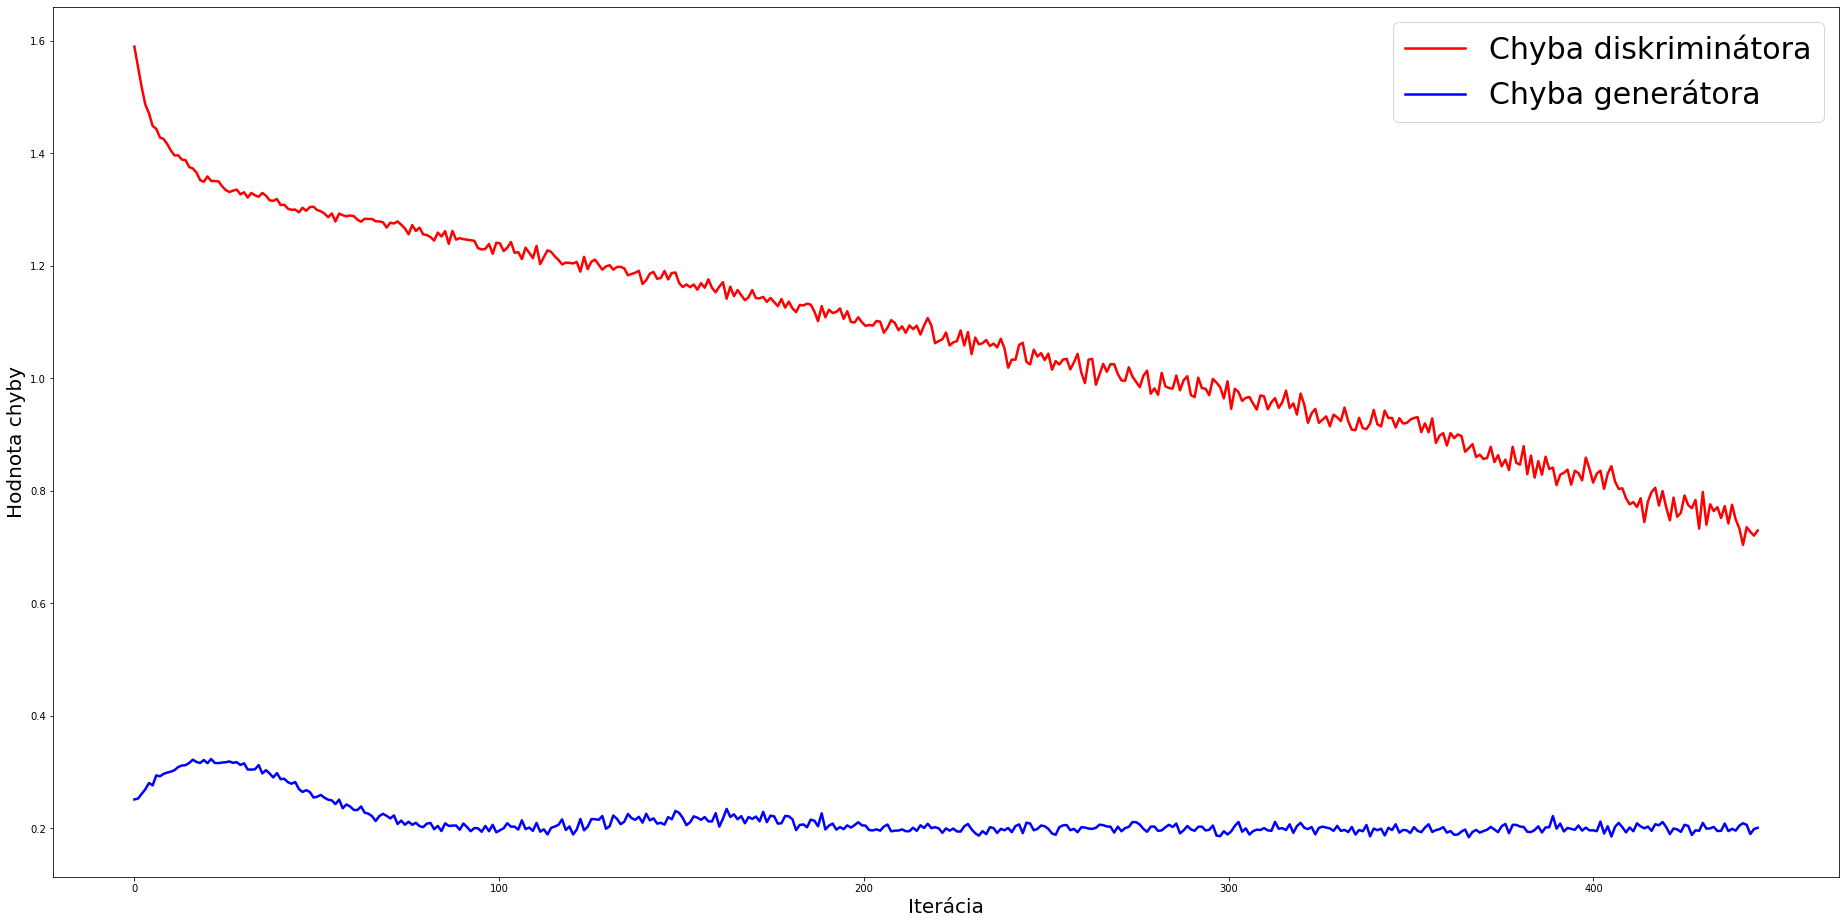

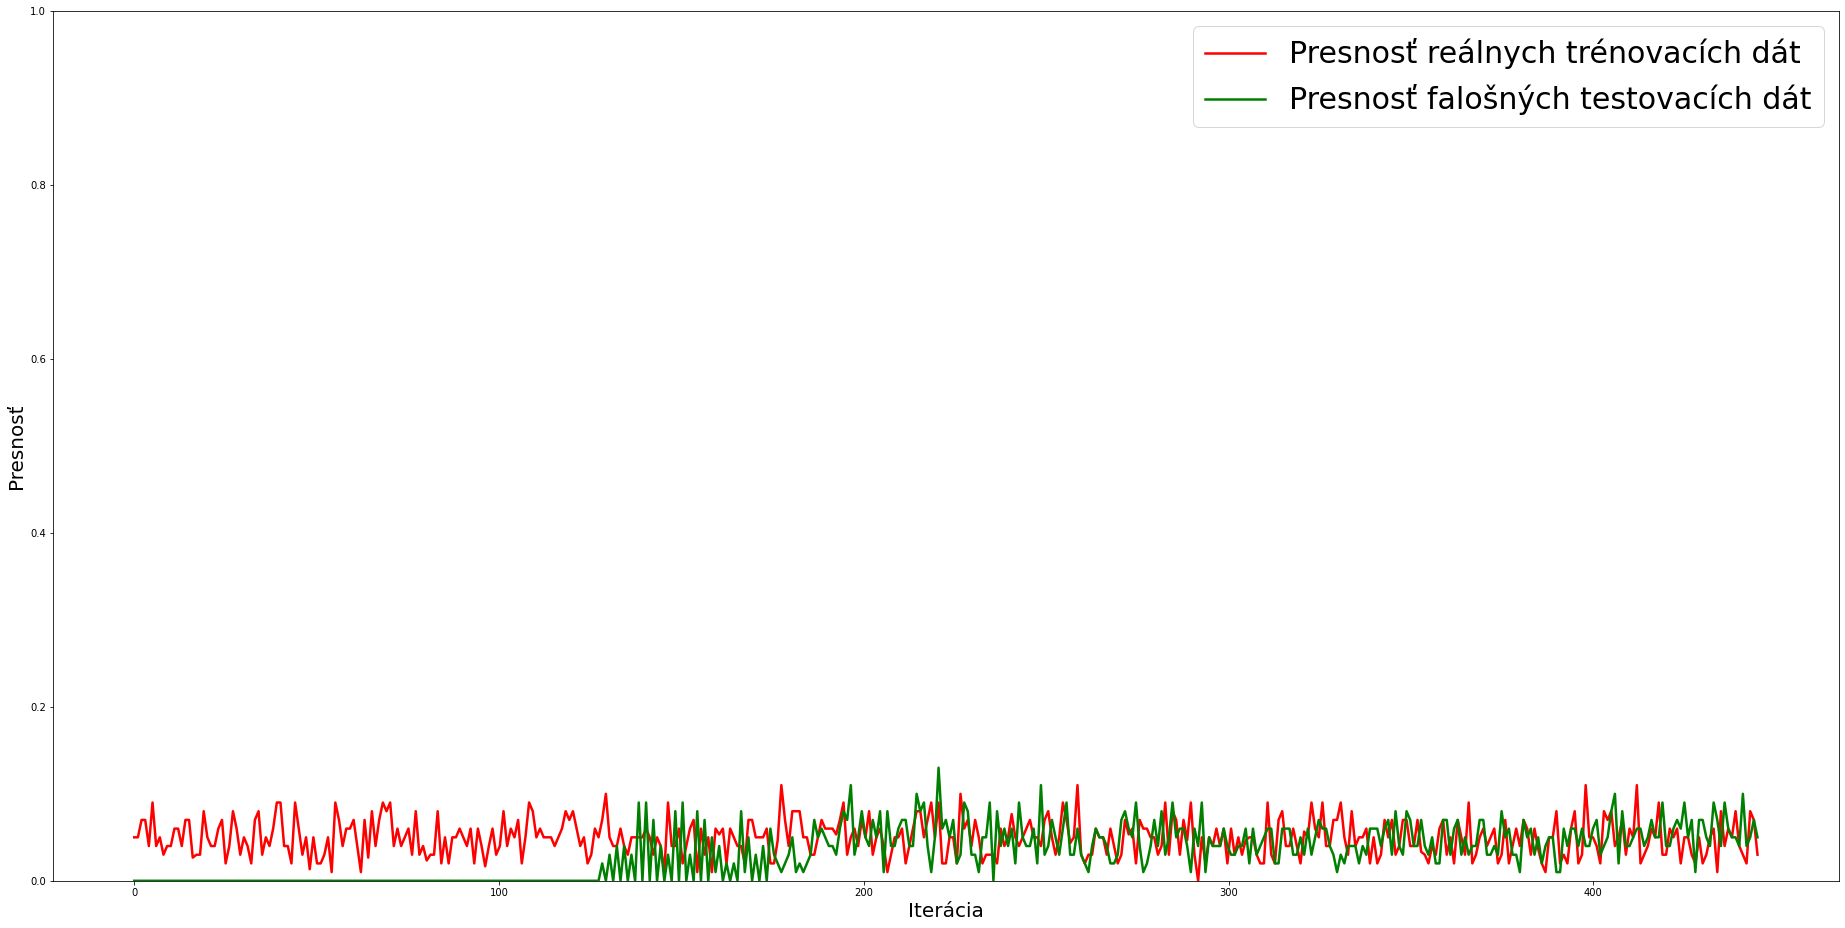

In [5]:


#chyba diskriminatoru a generatoru - #1140 iteracii -510min (8 a pol h)
d_fake_loss_graph_sgd3=np.load(WORKDIR_PATH / "d_fake_loss_graph_sgd3_latent01.npy") 
d_real_loss_graph_sgd3=np.load(WORKDIR_PATH / "d_real_loss_graph_sgd3_latent01.npy") 
d_loss_total=np.array(d_real_loss_graph_sgd3)+np.array(d_fake_loss_graph_sgd3) 
g_loss_graph_sgd3=np.load(WORKDIR_PATH / "g_loss_graph_sgd3_latent01.npy")

#prenost diskriminatoru - #1140 iteracii -510min (8 a pol h)
d_real_acc_graph_sgd3=np.load(WORKDIR_PATH / "d_real_acc_graph_sgd3_latent01.npy")
d_fake_acc_graph_sgd3=np.load(WORKDIR_PATH / "d_fake_acc_graph_sgd3_latent01.npy")

# filtered_acc_real2 = [ item for i,item in enumerate(d_real_acc_graph2) if i%100==0 ]
# filtered_acc_fake2 = [ item for i,item in enumerate(d_fake_acc_graph2) if i%100==0 ]
iterations=int(np.array(np.shape(d_fake_loss_graph_sgd3)))

time_axis=np.linspace(0,iterations,iterations)

fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Chyba diskriminátora', 'x': time_axis, 'y': d_loss_total[:], 'color':'r', 'linewidth':2.5},{'name': 'Chyba generátora', 'x': time_axis, 'y': g_loss_graph_sgd3[:], 'color':'b', 'linewidth':2.5}]
for signal in mysignals:
  #ax1 = fig.add_subplot(n, n, 1 + i)
  plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
  #ax1.axis('off')
  plt.legend(loc='upper right',prop={'size': 30})
  plt.xlabel('Iterácia',fontsize=20)
  plt.ylabel('Hodnota chyby',fontsize=20)
 
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Presnosť reálnych trénovacích dát', 'x': time_axis, 'y': d_real_acc_graph_sgd3[:], 'color':'r', 'linewidth':2.5},{'name': 'Presnosť falošných testovacích dát', 'x': time_axis, 'y': d_fake_acc_graph_sgd3[:], 'color':'g', 'linewidth':2.5}]
for signal in mysignals:
  #ax1 = fig.add_subplot(n, n, 1 + i)
  plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
  #ax1.axis('off')
  #ax1.axis('off')
  plt.legend(loc='upper right',prop={'size': 30})
  plt.xlabel('Iterácia',fontsize=20)
  plt.ylabel('Presnosť',fontsize=20)
  plt.ylim(0,1)